In [4]:
import time
import random
from typing import List
from pandas.core.frame import DataFrame

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.width = None
pd.options.display.max_colwidth = None
pd.options.display.float_format = '{:,.2f}'.format
import phik
from phik import resources, report


In [5]:
# ====================DUPLICATES CHECK====================

def duplicates_check(df: DataFrame, df_name: str) -> DataFrame:
    """Checks if there are any duplicated values in the dataframe and removes them.
    Input: df(DataFrame), df_name(name of the DataFrame)
    Returns: df"""
    
    print('-'*100)
    print(f"{df_name} had {df.shape[0]- df.drop_duplicates().shape[0]} rows removed")
    print('-'*100)
    if df.duplicated().sum() > 0:
        return df.drop_duplicates()
    return df

# ====================REDUCING MEMORY USAGE====================

def reduce_memory_usage(df: DataFrame) -> DataFrame:
    """Reduced memory usage by downcasting datatype of columns.
    Input: DataFrame
    Output: DataFrame"""

    for column in df:
        if df[column].dtype == "float64":
             df[column]=pd.to_numeric(df[column], downcast="float")
        if df[column].dtype == "int64":
            df[column]=pd.to_numeric(df[column], downcast="integer")
    print(df.info())
    return df

# ====================TARGET DISTRIBUTION====================

def pie_plot(df: DataFrame, col_name: str, labels: List) -> None:
    """Plots a pie chart of distribution of chosen column."""
    
    # Data to plot
    plot_data = df[col_name].value_counts() / df.shape[0]
    
    # Pie plot
    plt.title(f"Pie chart of {col_name} variable")
    plt.pie(plot_data, labels=labels, labeldistance=1.15, 
            wedgeprops= { 'linewidth' : 3, 'edgecolor' : 'white' }, autopct='%1.1f%%')
    
# ====================ASSIGN COLUMNS TO DATA TYPE====================

def get_object_columns(df: DataFrame, target_name: str) -> List:
    """Gets all features which categorical features of object type from the dataset.
    Parameters: df (DataFrame), target_name (name of the target column)
    Returns: list of names of categorical columns of object type"""
    
    # Make a list
    obj_col = df.select_dtypes(include='O').columns.to_list()
    # Check if target column in list
    if target_name in obj_col:
        obj_col.remove(target_name)
    # Return the list
    return obj_col

def get_cat_encoded_columns(df: DataFrame, target_name: str) -> List:
    """Gets all categorical features which are 0-1 encoded.
    Parameteres: df (DataFrame), target_name (name of the target column)
    Returns: list of names of columns of categorical encoded features"""
    
    # Initialize the list
    encoded_col = []
    # Check if columns values in 0 and 1
    for col in df.columns:
        if set([0 , 1]).issuperset(df[col].dropna()):
            encoded_col.append(col)
    # Checks if target column in list      
    if target_name in encoded_col:
        encoded_col.remove(target_name)
    #  Return the list of encoded columns     
    return encoded_col

def get_num_col(df: DataFrame, encoded_col: List, target_name: str, ordinal_col: List) -> List:
    """Gets numerical continuous column names from the dataset.
    Parameters: df (DataFrame), encoded_col (list of categorical 
    values encoded to 0-1, target_name (name of target colum),
    ordinal_col (list of ordinally encoded variables)
    Returns: list of numerical continuous values."""
    
    # Make a list of all numerical values
    num_col = df.select_dtypes(exclude='O').columns.to_list()
    # Remove encoded categorical columns
    num_col = [col for col in num_col if col not in encoded_col]
    # Checks if target column in list      
    if target_name in num_col:
        num_col.remove(target_name)
    num_col = [x for x in num_col if x not in ordinal_col]
    # Return numerical continuous list
    return num_col

# ====================STATISTICAL CORRELATIONS CHECK WITH TARGET====================

def corr_check_num_cat(df: DataFrame, target_name: str, numerical_col: List) -> List:
    """Calculates p_value for anova test to check if the numerical variables are correlated
    with target. If p_value is less then significance level 0.05 rejcts the null hypothesis 
    that variables are not correlated. 
    Paramteres: df (DataFrame), target_name (name of the target column as str), 
    numerical_col (list of numerical continuous columns).
    Returns a list of potentially correlated columns."""
    
    from scipy.stats import f_oneway
    
    # Go through all variables and append results
    p_values = []
    for col in numerical_col:
        category_group_list = df[[col, target_name]].dropna().groupby(col)[target_name].apply(list)
        anova = f_oneway(*category_group_list)
        p_values.append(anova[1])
    anova_df = pd.DataFrame({'column_name': numerical_col, 'p_value': p_values}).sort_values(by='p_value')
    # List of column names where we can reject the null hypothesis 
    # that the variables are not correlated with each other
    corr_col = anova_df[anova_df["p_value"] < 0.05]['column_name'].to_list()
    # Prints columns that are correlated with target
    print('-'*100)
    print(f'The columns that are correlated with target column: {corr_col}')
    print('-'*100)
    # Return the list of correlated columns
    return corr_col

def corr_check_cat_cat(df: DataFrame, target_name:str, cat_col: List) -> List:
    """Performs Chi_Sq test for two categorical variables and finds
    the probability of null hypothesis.
    H0: The two columns are NOT related to each other
    alpha: 0.05
    Parameters: df (DataFrame), target_name (name of target column as str),
    cat_col (list of all categorical columns)
    Returns: a list of potentially correlated columns.
    """
    from scipy.stats import chi2_contingency

    # Go through all variables and append results
    p_values = []
    for col in cat_col:
        cross_result = pd.crosstab(index=df[col], columns=df[target_name])
        chi_square = chi2_contingency(cross_result)
        p_values.append(chi_square[1])
    # DataFrame with p_values and names of columns
    chi_square_df = pd.DataFrame({'column_name': cat_col, 'p_value': p_values}).sort_values(by='p_value')
    # List of column names where we can reject the null hypothesis that the variables are not correlated with each other
    corr_col = chi_square_df[chi_square_df["p_value"] < 0.05]['column_name'].to_list()
    # Print out the names of columns correlated with target
    print('-'*100)
    print(f'The columns that are correlated with target column: {corr_col}')
    print('-'*100)
    # Return correlated columns
    return corr_col

# ====================CORRELATIONS BETWEEN NUMERICAL FEATURES====================

def magnify() -> List:
    '''Function that magnifies clicked value in DataFrame.'''
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])]

def high_corr_background(cell_value: any) -> str:
    '''Assigns background of the cell based on the value. 
    Highlights highly correlated columns with correlation 
    higher than 0.7 to red, lower than -0.7 to blue and 
    1 to green.'''
    
    # Set the colors
    highlight_positive = 'background-color: red'
    highlight_negative = 'background-color: blue'
    default = 'background-color: white'
    onces = 'background-color: green'
    
    # Conditions
    if type(cell_value) in [float, int]:
        if (cell_value>=0.7 and cell_value<1.0):
            return highlight_positive
        elif cell_value <=-0.7:
            return highlight_negative
        elif cell_value == 1.0:
            return onces
    return default

def pearson_corr_df(df: DataFrame) -> None:
    '''Calculates Pearson correlations between numerical features.
    Displays styled dataframes for visual clarity of correlations.'''
    
    for n in range(1, df.shape[1]//10+1):
        corr = df.corr().iloc[:, (n-1)*10:n*10]
        display(corr.style.applymap(high_corr_background)\
        .format(precision=2)\
        .set_properties(**{'max-width': '60px', 'font-size': '8pt'})\
        .set_caption("Pearson correaltions of numerical columns")\
        .set_table_styles(magnify()))
        
# ====================TOP CORRELATED FEATURES WITH TARGET====================

def target_top_corr(df: DataFrame, target_name: str, columns: List, number_of_corr_col: int=10, numerical: bool=True) -> DataFrame:
    '''
    Returns DataFrame with top correlated features with the target columns.
    Paramteres: df (DataFrame), columns (list of columns to inspect),
    target_name (name of target column as str),
    num_of_corr_col (number of columns correlated with the target as int),
    numerical (if the data is continuous as boolean value)
    Returns: DataFrame with most correllated columns.
    '''

    # Calculating phick, spearman and pearson correlations of continuous variables with target 
    if numerical: 
        # Initializing list of values
        phik_values = []
        spearman_values = []
        pearson_values = []
        for column in columns:
            # Appending values of correlations
            df_check = df[[target_name, column]]
            phik_values.append(df_check.phik_matrix(interval_cols=[target_name, column]).iloc[0,1])
            spearman_values.append(df_check.corr(method='spearman').iloc[0, 1])
            pearson_values.append(df_check.corr().iloc[0, 1])
        # Building dataframe 
        top_phik_corr = pd.DataFrame({#'column_name': columns, 
                                  'phik_correlation' : phik_values,
                                'phik_abs_correlation' : [abs(x) for x in phik_values],
                                  'spearman_correlation': spearman_values,
                                 'pearson_correlation': pearson_values}, index=columns)
        top_phik_corr = top_phik_corr.sort_values(by = 'phik_abs_correlation', ascending = False)
        return top_phik_corr.iloc[:number_of_corr_col]
    
    # Calculating the phik correlations of categorical variables with target 
    else:
        col = columns + [target_name]
        data_for_phik = df[col].astype('object')
        phik_matrix = data_for_phik.phik_matrix()
        return (phik_matrix[target_name].sort_values(ascending=False).to_frame()
                .rename(columns={target_name: 'phik_correlation'}).iloc[1:number_of_corr_col+1])
    
# ====================PLOTTING CONTINUOUS VARIABLES====================

def plot_num(df: DataFrame, target_name: str, num_columns: List, labels: List) -> None:
    """Plots boxplots and ecdfplot of numerical columns in regards to target column.
    Parameteres: df (DataFrame), target_name (name of target column as str),
    num_columns (numerical columns for plotting), labels (list of labels)
    Returns: None
    """
    
    # Calculate the number of rows
    rows = len(num_columns)
     
    # Plot numerical features over target
    fig, ax = plt.subplots(rows, 2, figsize=(18, rows*4), tight_layout=True)
    fig.suptitle("Numerical features vs target", fontweight="bold", y=1.00, fontsize=14)
    x = [0, 1]
    for i in range(rows):
        for j in range(2):
            col = num_columns[i]
            if j == 0:
                # Plot boxplot
                sns.boxplot(data=df[[target_name, col]].dropna(), x=target_name, y=col, ax=ax[i, j])
                ax[i, j].set_title(f"{col} vs {target_name} boxplot", fontsize=10, fontweight='bold')
                ax[i, j].set_xticks(x, labels)
                ax[i, j].set_xlabel("")
            else:
                # Plot kde
                sns.kdeplot(data=df[[target_name, col]].dropna(), x=col, hue=target_name, common_norm=False, ax=ax[i, j])
                ax[i, j].set_title(f"{col} vs {target_name} kde ", fontsize=10, fontweight='bold')
                ax[i, j].legend(labels[::-1])

# ====================PLOTTING CATEGORICAL VARIABLES====================

def plot_cat_bars(df: DataFrame, target_name: str, categorical_columns: List) -> None:
    """Plots bars for all categorical features in dataframe
    in relation to target variable as two column subplots.
    Paramteres: df (DataFrame), target_name (name of the target column as str),
    categorical_columns (list of names of categorical columns"""
    
    import math
    
    # Calculate the number of rows
    rows = math.ceil(len(categorical_columns)/2)
     
    # Plot categories over target
    fig, ax = plt.subplots(rows, 2, figsize=(18, rows*4), tight_layout=True)
    fig.suptitle("Categorical features vs target", fontweight="bold", y=1.00, fontsize=14)

    for i in range(rows):
        for j in range(2):
            if (i*2+j) < len(categorical_columns):
                col = categorical_columns[i * 2 + j]
                # Perapare data to plot
                df_plot = pd.crosstab(df[col], df[target_name]).apply(
                    lambda x: round(x / sum(x) * 100, 2), axis=0
                )
                # Plot data
                df_plot.plot(kind="bar", ax=ax[i, j])
                # Add bar labels
                ax[i, j].bar_label(
                    ax[i, j].containers[0],
                    fmt="%.0f%%",
                    padding=5,
                    size=7,
                    color="black",
                    fontweight="bold",
                )
                ax[i, j].bar_label(
                    ax[i, j].containers[1],
                    fmt="%.0f%%",
                    padding=4,
                    size=7,
                    color="black",
                    fontweight="bold",
                )
                ax[i, j].set_yticks([])
                ax[i, j].set_xticklabels(ax[i, j].get_xticklabels(), rotation=90, size=8)
                ax[i, j].set_xlabel("")
                ax[i, j].set_title(f"{col} vs {target_name}", fontsize=10, fontweight='bold')
                ax[i, j].legend()
                ax[i, j].get_legend().remove()
                sns.despine(left=True)
    # Remove unused axes
    if rows*2 != len(categorical_columns):
        fig.delaxes(ax[rows-1, 1])
    # Add legend
    fig.legend(labels=[0, 1], title=target_name, bbox_to_anchor=(1.05, 0.90));
    
# ====================PLOTTING MISSING VALUES====================

def plot_missing(df: DataFrame, df_name: str) -> None:
    """Plots bar graph with percentages of missing values in the dataframe."""

    nr_col_nan = (df.isna().sum(axis=0) > 0).sum()
    print('-'*100)
    print(f"Number of columns in {df_name}: {df.shape[1]} columns")
    print(f"Number of columns with missing values in {df_name}: {nr_col_nan} columns")
    print('-'*100)
    # Data to plot
    plot_data = (df.isnull().mean().reset_index().rename(columns={'index': 'column', 0: 'fraction'})
    .sort_values(by='fraction', ascending=False)[:nr_col_nan])
    # Plotting the Bar-Plot for NaN percentages 
    plt.figure(figsize = (20, 8), tight_layout = True)
    sns.barplot(x='column', y='fraction', data=plot_data )
    plt.xticks(rotation = 90)
    plt.xlabel("")
    plt.title(f'Fraction of NaN values in {df_name}')

# EDA

This process will take a couple of steps for each set of data:

1) Loading data using pandas
2) Reducing memory usage by custom encoding for each dataset, checking for duplicates and using reduce_memory_usage function
3) Splitting data to analyse only train data
4) Inspecting distribution of target
5) Categorizing columns based on type of data
6) EDA of continuous features:
* checking significance of correlations with target with anova test, 
* removing multicollinear features,
* checking correlations with target using phik, spearman and pearson correlation
* checking for missing values in features with highiest correlations
* plotting a number of features with highiest correlations, making conclusions
6) EDA of categorical variables: 
* checking significance of correlations with target with chi-square test, 
* removing features that are correlated with each other based on spearman correlation,
* checking correlations with phik test,
* plotting a number of features with highiest correlations.

## application_train.csv
### Loading data

In [6]:
df = pd.read_csv('application_train.csv')
df.head(2)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,"202,500.00","406,597.50","24,700.50","351,000.00",Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.02,-9461,-637,"-3,648.00",-2120,NaN,1,1,0,1,1,0,Laborers,1.00,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.08,0.26,0.14,0.02,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,0.03,0.04,0.97,0.63,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,0.03,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,reg oper account,block of flats,0.01,"Stone, brick",No,2.00,2.00,2.00,2.00,"-1,134.00",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,1.00
1,100003,0,Cash loans,F,N,N,0,"270,000.00","1,293,502.50","35,698.50","1,129,500.00",Family,State servant,Higher education,Married,House / apartment,0.00,-16765,-1188,"-1,186.00",-291,NaN,1,1,0,1,1,0,Core staff,2.00,1,1,MONDAY,11,0,0,0,0,0,0,School,0.31,0.62,NaN,0.10,0.05,0.99,0.80,0.06,0.08,0.03,0.29,0.33,0.01,0.08,0.05,0.00,0.01,0.09,0.05,0.99,0.80,0.05,0.08,0.03,0.29,0.33,0.01,0.08,0.06,0.00,0.00,0.10,0.05,0.99,0.80,0.06,0.08,0.03,0.29,0.33,0.01,0.08,0.06,0.00,0.01,reg oper account,block of flats,0.07,Block,No,1.00,0.00,1.00,0.00,-828.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00


Let's check the information about the data.

In [7]:
df.info(), df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


(None, (307511, 122))

The application data has 307,511 entries and 122 columns. 

Let's reduce the space the data takes.

### Reducing memory usage

* checking for duplicates
* using design function to reduce the datatype
* encoding low cardinality categorical columns

In [5]:
df = duplicates_check(df, 'application_train.csv')

----------------------------------------------------------------------------------------------------
application_train.csv had 0 rows removed
----------------------------------------------------------------------------------------------------


In [8]:
# Calling function to reduce the memory usage
df = reduce_memory_usage(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float32(64), float64(1), int16(2), int32(2), int8(37), object(16)
memory usage: 129.3+ MB
None


By minimizing the data type we were able to reduce the size of dataframe by more than half.

Now let's reduce the data size even further by checking which categorical columns could be encoded to numbers.

In [7]:
# Categorical columns that are of object type
object_col = get_object_columns(df, 'TARGET')

for col in object_col:
    print(f'{col}: {df[col].unique()}')

NAME_CONTRACT_TYPE: ['Cash loans' 'Revolving loans']
CODE_GENDER: ['M' 'F' 'XNA']
FLAG_OWN_CAR: ['N' 'Y']
FLAG_OWN_REALTY: ['Y' 'N']
NAME_TYPE_SUITE: ['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' nan
 'Other_B' 'Group of people']
NAME_INCOME_TYPE: ['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave']
NAME_EDUCATION_TYPE: ['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
NAME_FAMILY_STATUS: ['Single / not married' 'Married' 'Civil marriage' 'Widow' 'Separated'
 'Unknown']
NAME_HOUSING_TYPE: ['House / apartment' 'Rented apartment' 'With parents'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']
OCCUPATION_TYPE: ['Laborers' 'Core staff' 'Accountants' 'Managers' nan 'Drivers'
 'Sales staff' 'Cleaning staff' 'Cooking staff' 'Private service staff'
 'Medicine staff' 'Security staff' 'High skill tech staff'
 'Waiters/barmen staff' 'Low-skil

TODO:
* replace 'XNA' with np.nan
* reduce the categories in organization type
* replace yes, y to 1, replace no, n to 0

In [6]:
def organization_replacer(value: any) -> any:
    """Reduces the number of unique values 
    where there are subcategories with ':' sign"""
    
    if value not in [np.nan, None]:
        x = value.split()[0]
        if x[-1] ==":":
            return x[:-1]
    return value

def yes_no_replacer(value: str) -> int:
    """Encodes yes, no columns to 0 and 1"""
    if value is ['Y', 'Yes']:
        return 1
    elif value in ['N', 'No']:
        return 0
    
# Replace yes no
yes_no_col = ['FLAG_OWN_CAR', 'EMERGENCYSTATE_MODE', 'FLAG_OWN_REALTY']
for col in yes_no_col :
    df[col] = df[col].map(yes_no_replacer)

# Replace 'XNA'
df.replace({'XNA': np.nan}, inplace=True)

# Replace organization
df['ORGANIZATION_TYPE'] = df['ORGANIZATION_TYPE'].map(organization_replacer)

### Splitting data

In [12]:
from sklearn.model_selection import train_test_split
# Get features and target
X = df.drop('TARGET', axis=1)
y = df['TARGET']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100, stratify=y)

# Get the data for eda
df_eda = pd.merge(X_train, y_train, left_index=True, right_index=True)

# Getting unique values of application identification number for analysis with other tables
app_id_eda = df_eda['SK_ID_CURR'].unique()

In [ ]:
# Dropping sk_id_curr
df_eda = df_eda.drop('SK_ID_CURR', axis=1)

In [6]:
del df

In [10]:
df_eda.shape

(246008, 121)

### Plotting distribution of target variable

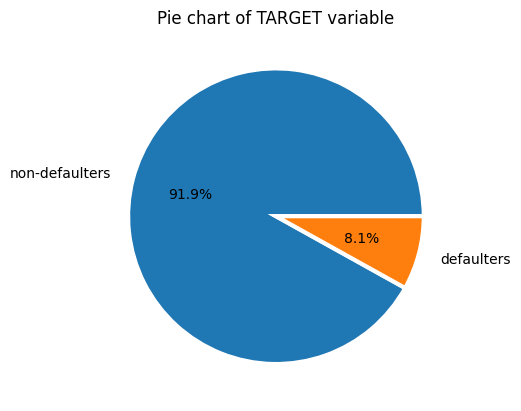

In [11]:
pie_plot(df_eda, 'TARGET', ['non-defaulters', 'defaulters'])

### Categorizing columns based on type of data

In [12]:
# Categorical columns that are of object type
object_col = get_object_columns(df_eda, 'TARGET')

# Categorical ordinal columns
ordinal_col = ['REGION_RATING_CLIENT']

# Categorical features that are encoded
encoded_col = get_cat_encoded_columns(df_eda, 'TARGET')

# All categorical features
cat_col = object_col + encoded_col + ordinal_col

# Numerical continuous variables
num_col = get_num_col(df_eda, encoded_col, 'TARGET', ordinal_col)

In [13]:
assert len(cat_col) + len(num_col) == df_eda.shape[1] - 1, "The condition is not true"

### EDA of continuous features

#### Checking significance of correlations with target with anova test

In [14]:
# Getting columns that are correlated with target 
numerical_corr = corr_check_num_cat(df_eda, 'TARGET', num_col)

----------------------------------------------------------------------------------------------------
The columns that are correlated with target column: ['EXT_SOURCE_3', 'EXT_SOURCE_2', 'REGION_POPULATION_RELATIVE', 'AMT_GOODS_PRICE', 'REGION_RATING_CLIENT_W_CITY', 'AMT_ANNUITY', 'AMT_CREDIT', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'OWN_CAR_AGE', 'FLOORSMAX_MODE', 'FLOORSMAX_MEDI', 'EXT_SOURCE_1', 'HOUR_APPR_PROCESS_START', 'CNT_CHILDREN', 'ELEVATORS_MODE', 'CNT_FAM_MEMBERS', 'FLOORSMIN_MODE', 'AMT_REQ_CREDIT_BUREAU_QRT', 'ELEVATORS_MEDI', 'FLOORSMIN_MEDI', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'ENTRANCES_MEDI', 'FLOORSMAX_AVG', 'ENTRANCES_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'DAYS_BIRTH', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE', 'YEARS_BUILD_MODE', 'ELEVATORS_AVG', 'YEARS_BUILD_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'AMT_REQ_CREDIT_BUREAU_MON', 'YEARS_BUILD_AVG', 'FLOORSMIN_AVG', 'OBS_60_CNT_SOCIAL_CIRCLE', 'YEARS_BEGINEXPLUATATION_AVG', 'OBS_30_CNT_SOCIAL_CIRCLE']
----

In [15]:
print(f'Number of numerical columns that are not correlated with target: {len(num_col) - len(numerical_corr)}')

Number of numerical columns that are not correlated with target: 32


#### Inspecting and removing multicollinear features

In [16]:
# Displaying Pearson correlations between numerical features correlated to target variable
df_pearson = df_eda[numerical_corr]
pearson_corr_df(df_pearson)

,EXT_SOURCE_3,EXT_SOURCE_2,REGION_POPULATION_RELATIVE,AMT_GOODS_PRICE,REGION_RATING_CLIENT_W_CITY,AMT_ANNUITY,AMT_CREDIT,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,OWN_CAR_AGE
EXT_SOURCE_3,1.00,0.11,-0.01,0.05,-0.01,0.03,0.04,-0.04,-0.04,-0.02
EXT_SOURCE_2,0.11,1.00,0.20,0.14,-0.29,0.13,0.13,-0.03,-0.03,-0.08
REGION_POPULATION_RELATIVE,-0.01,0.20,1.00,0.10,-0.53,0.12,0.10,0.01,0.00,-0.08
AMT_GOODS_PRICE,0.05,0.14,0.10,1.00,-0.11,0.77,0.99,-0.02,-0.02,-0.10
REGION_RATING_CLIENT_W_CITY,-0.01,-0.29,-0.53,-0.11,1.00,-0.14,-0.11,0.01,0.02,0.09
AMT_ANNUITY,0.03,0.13,0.12,0.77,-0.14,1.00,0.77,-0.02,-0.02,-0.10
AMT_CREDIT,0.04,0.13,0.10,0.99,-0.11,0.77,1.00,-0.02,-0.02,-0.10
DEF_30_CNT_SOCIAL_CIRCLE,-0.04,-0.03,0.01,-0.02,0.01,-0.02,-0.02,1.00,0.86,0.01
DEF_60_CNT_SOCIAL_CIRCLE,-0.04,-0.03,0.00,-0.02,0.02,-0.02,-0.02,0.86,1.00,0.01
OWN_CAR_AGE,-0.02,-0.08,-0.08,-0.10,0.09,-0.10,-0.10,0.01,0.01,1.00


,FLOORSMAX_MODE,FLOORSMAX_MEDI,EXT_SOURCE_1,HOUR_APPR_PROCESS_START,CNT_CHILDREN,ELEVATORS_MODE,CNT_FAM_MEMBERS,FLOORSMIN_MODE,AMT_REQ_CREDIT_BUREAU_QRT,ELEVATORS_MEDI
EXT_SOURCE_3,0.00,0.00,0.19,-0.04,-0.04,0.01,-0.03,0.00,-0.02,0.01
EXT_SOURCE_2,0.13,0.13,0.21,0.16,-0.02,0.11,-0.00,0.10,-0.00,0.11
REGION_POPULATION_RELATIVE,0.30,0.32,0.10,0.17,-0.02,0.25,-0.02,0.27,-0.00,0.27
AMT_GOODS_PRICE,0.11,0.11,0.18,0.06,-0.00,0.08,0.06,0.08,0.01,0.08
REGION_RATING_CLIENT_W_CITY,-0.23,-0.25,-0.12,-0.27,0.02,-0.21,0.03,-0.22,0.00,-0.23
AMT_ANNUITY,0.12,0.13,0.12,0.05,0.02,0.09,0.08,0.09,0.01,0.10
AMT_CREDIT,0.10,0.10,0.17,0.05,0.00,0.07,0.06,0.07,0.01,0.08
DEF_30_CNT_SOCIAL_CIRCLE,-0.03,-0.03,-0.03,-0.00,-0.00,-0.02,-0.00,-0.02,-0.00,-0.02
DEF_60_CNT_SOCIAL_CIRCLE,-0.03,-0.03,-0.03,-0.01,-0.00,-0.02,-0.01,-0.02,-0.00,-0.02
OWN_CAR_AGE,-0.08,-0.08,-0.08,-0.07,0.01,-0.06,-0.01,-0.07,-0.02,-0.06


,FLOORSMIN_MEDI,AMT_REQ_CREDIT_BUREAU_YEAR,ENTRANCES_MEDI,FLOORSMAX_AVG,ENTRANCES_MODE,YEARS_BEGINEXPLUATATION_MODE,DAYS_BIRTH,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,YEARS_BUILD_MODE
EXT_SOURCE_3,0.00,-0.07,0.01,0.00,0.01,-0.00,-0.20,-0.13,-0.07,0.01
EXT_SOURCE_2,0.11,-0.02,0.03,0.13,0.02,0.01,-0.09,-0.05,-0.20,0.01
REGION_POPULATION_RELATIVE,0.29,0.00,0.03,0.32,0.01,-0.01,-0.03,-0.01,-0.04,-0.07
AMT_GOODS_PRICE,0.08,-0.05,0.02,0.11,0.01,0.00,-0.05,-0.01,-0.08,0.04
REGION_RATING_CLIENT_W_CITY,-0.23,0.01,-0.03,-0.25,-0.01,-0.00,0.01,-0.01,0.03,0.04
AMT_ANNUITY,0.10,-0.01,0.01,0.13,0.01,0.01,0.01,0.01,-0.06,0.03
AMT_CREDIT,0.08,-0.05,0.01,0.10,0.01,0.00,-0.06,-0.01,-0.07,0.03
DEF_30_CNT_SOCIAL_CIRCLE,-0.02,0.02,-0.00,-0.03,-0.00,-0.00,-0.00,0.00,0.00,-0.01
DEF_60_CNT_SOCIAL_CIRCLE,-0.02,0.02,-0.01,-0.03,-0.01,-0.00,-0.00,0.00,0.00,-0.01
OWN_CAR_AGE,-0.07,-0.01,-0.02,-0.08,-0.01,0.00,0.01,0.01,0.00,-0.05


Looking at the correlations between numerical features we see correlations:
1) AMT_GOODS_PRICE - AMT_ANNUITY - AMT_CREDIT
2) REGION_RATING_CLIENT_W_CITY - REGION_RATING_CLIENT
3) AMT_ANNUITY - AMT_CREDIT
4) DEF_30_CNT_SOCIAL_CIRCLE - DEF_60_CNT_SOCIAL_CIRCLE
5) FLOORSMAX_MODE - FLOORSMAX_MEDI - FLOORSMIN_MODE - FLOORSMIN_MEDI - FLOORSMAX_AVG - FLOORSMIN_AVG
6) FLOORSMAX_MEDI - FLOORSMIN_MODE - FLOORSMIN_MEDI - FLOORSMAX_AVG - FLOORSMIN_AVG
7) CNT_CHILDREN - CNT_FAMILY_MEMBERS
8) ELEVATORS_MODE - ELEVATORS_MEDI - ELEVATORS_AVG
9) FLOORSMIN_MODE - FLOORSMIN_MEDI - FLOORSMIN_AVG - FLOORSMAX_AVG
10) ELEVATORS_MEDI - ELEVATORS_AVG
11) FLOORSMIN_MEDI - FLOORSMAX_AVG - FLOORSMIN_AVG
12) ENTRANCES_MEDI - ENTRANCES_MODE
13) FLOORSMAX_AVG - FLOORSMIN_AVG
14) YEARS_BEGINEXPLUATATION_MODE - YEARS_BEGINXPLUATATION_MEDI - YEARS_BEGINXPLUATATION_AVG
15) YEARS_BUILD_MODE - YEARS_BUILD_MEDI - YEARS_BUILD_AVG
16) YEARS_BUILD_MEDI - YEARS_BUILD_AVG
17) YEARS_BEGINXPLUATATION_MEDI - YEARS_BEGINXPLUATATION_AVG
18) OBS_60_CNT_SOCIAL_CIRCLE - OBS_30_CNT_SOCIAL_CIRCLE


As we need to remove multicolinear features we will remove columns: 
['AMT_GOODS_PRICE', 'REGION_RATING_CLIENT_W_CITY',  'FLOORSMIN_AVG', 'FLOORSMIN_MODE', 'FLOORSMAX_AVG', 'FLOORSMAX_MODE', 'ELEVATORS_MODE', 'ELEVATORS_AVG', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'CNT_FAM_MEMBERS', 'FLOORSMIN_MEDI', 'ENTRANCES_MODE']

In [17]:
# Getting names of multicollinear features
multicollinear_features = ['AMT_GOODS_PRICE', 'REGION_RATING_CLIENT_W_CITY', 'FLOORSMIN_AVG', 'FLOORSMIN_MODE',
                           'FLOORSMAX_AVG', 'FLOORSMAX_MODE', 'ELEVATORS_MODE', 'ELEVATORS_AVG',
                           'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'YEARS_BUILD_MODE',
                           'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'CNT_FAM_MEMBERS', 'FLOORSMIN_MEDI', 'ENTRANCES_MODE', 'AMT_ANNUITY']

# Getting numerical features that are correlated to the target but not with each other
numerical = [i for i in numerical_corr if i not in multicollinear_features]

#### Checking correlations with target using phik, spearman and pearson correlation

In [18]:
df_corr_num = target_top_corr(df_eda, 'TARGET', numerical)
df_corr_num

,phik_correlation,phik_abs_correlation,spearman_correlation,pearson_correlation
EXT_SOURCE_3,0.25,0.25,-0.17,-0.18
EXT_SOURCE_1,0.22,0.22,-0.15,-0.16
EXT_SOURCE_2,0.22,0.22,-0.15,-0.16
DAYS_BIRTH,0.10,0.10,0.08,0.08
DAYS_LAST_PHONE_CHANGE,0.07,0.07,0.06,0.06
OWN_CAR_AGE,0.06,0.06,0.05,0.04
FLOORSMAX_MEDI,0.06,0.06,-0.04,-0.04
AMT_CREDIT,0.06,0.06,-0.02,-0.03
DAYS_ID_PUBLISH,0.05,0.05,0.05,0.05
REGION_POPULATION_RELATIVE,0.04,0.04,-0.03,-0.04


In [19]:
# Getting numbers
num_col_plot = df_corr_num.index.to_list()

#### Displaying meaning of numerical columns with highiest correlelations to target

In [34]:
names = pd.read_csv("HomeCredit_columns_description.csv", encoding='Latin-1', index_col=0)

In [33]:
names = pd.read_csv("HomeCredit_columns_description.csv", encoding='Latin-1', index_col=0)
names.loc[(names['Table']=='application_{train|test}.csv')&(names['Row'].isin(num_col_plot))][['Row', 'Description', 'Special']]

NameError: name 'num_col_plot' is not defined

#### Checking for missing values in features with highiest correlations

----------------------------------------------------------------------------------------------------
Number of columns in Missing values in numerical columns with highiest correlation to target: 10 columns
Number of columns with missing values in Missing values in numerical columns with highiest correlation to target: 6 columns
----------------------------------------------------------------------------------------------------


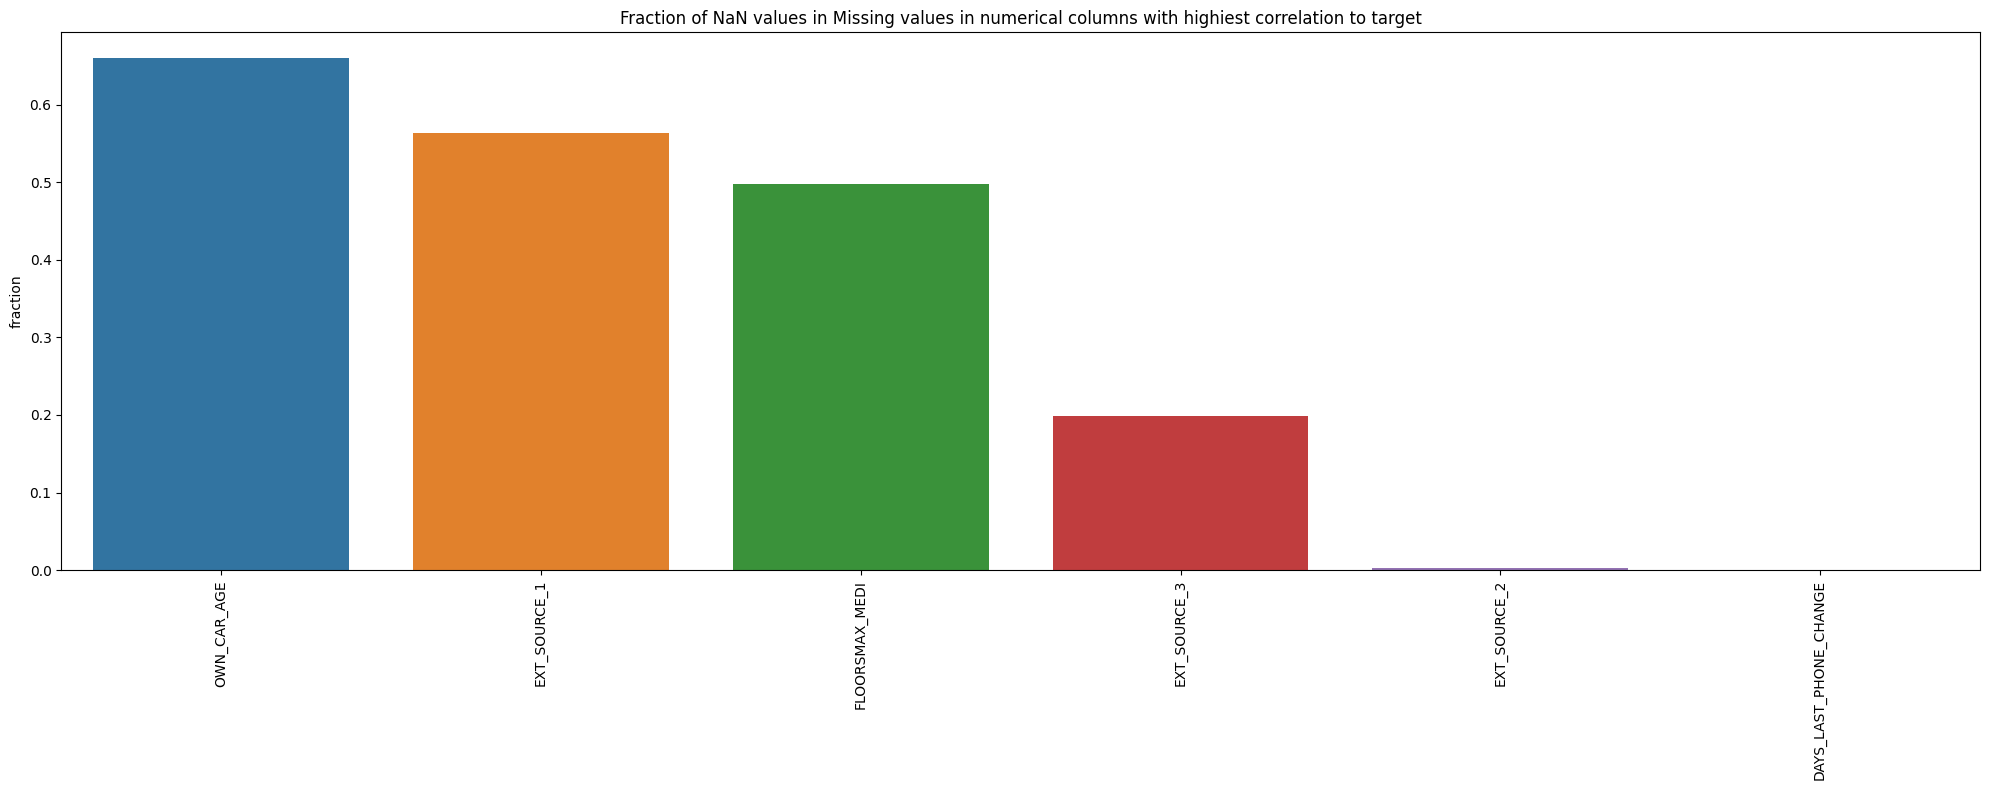

In [21]:
plot_missing(df_eda[num_col_plot], 'Missing values in numerical columns with highiest correlation to target')

The factions of missing values in features that are correlated to target are more than 0.2 for 4 features. OWN_CAR_AGE and EXT_SOURCE_1 have more than 50% missing values.  

#### Plotting continuous variables which are correlated with the target

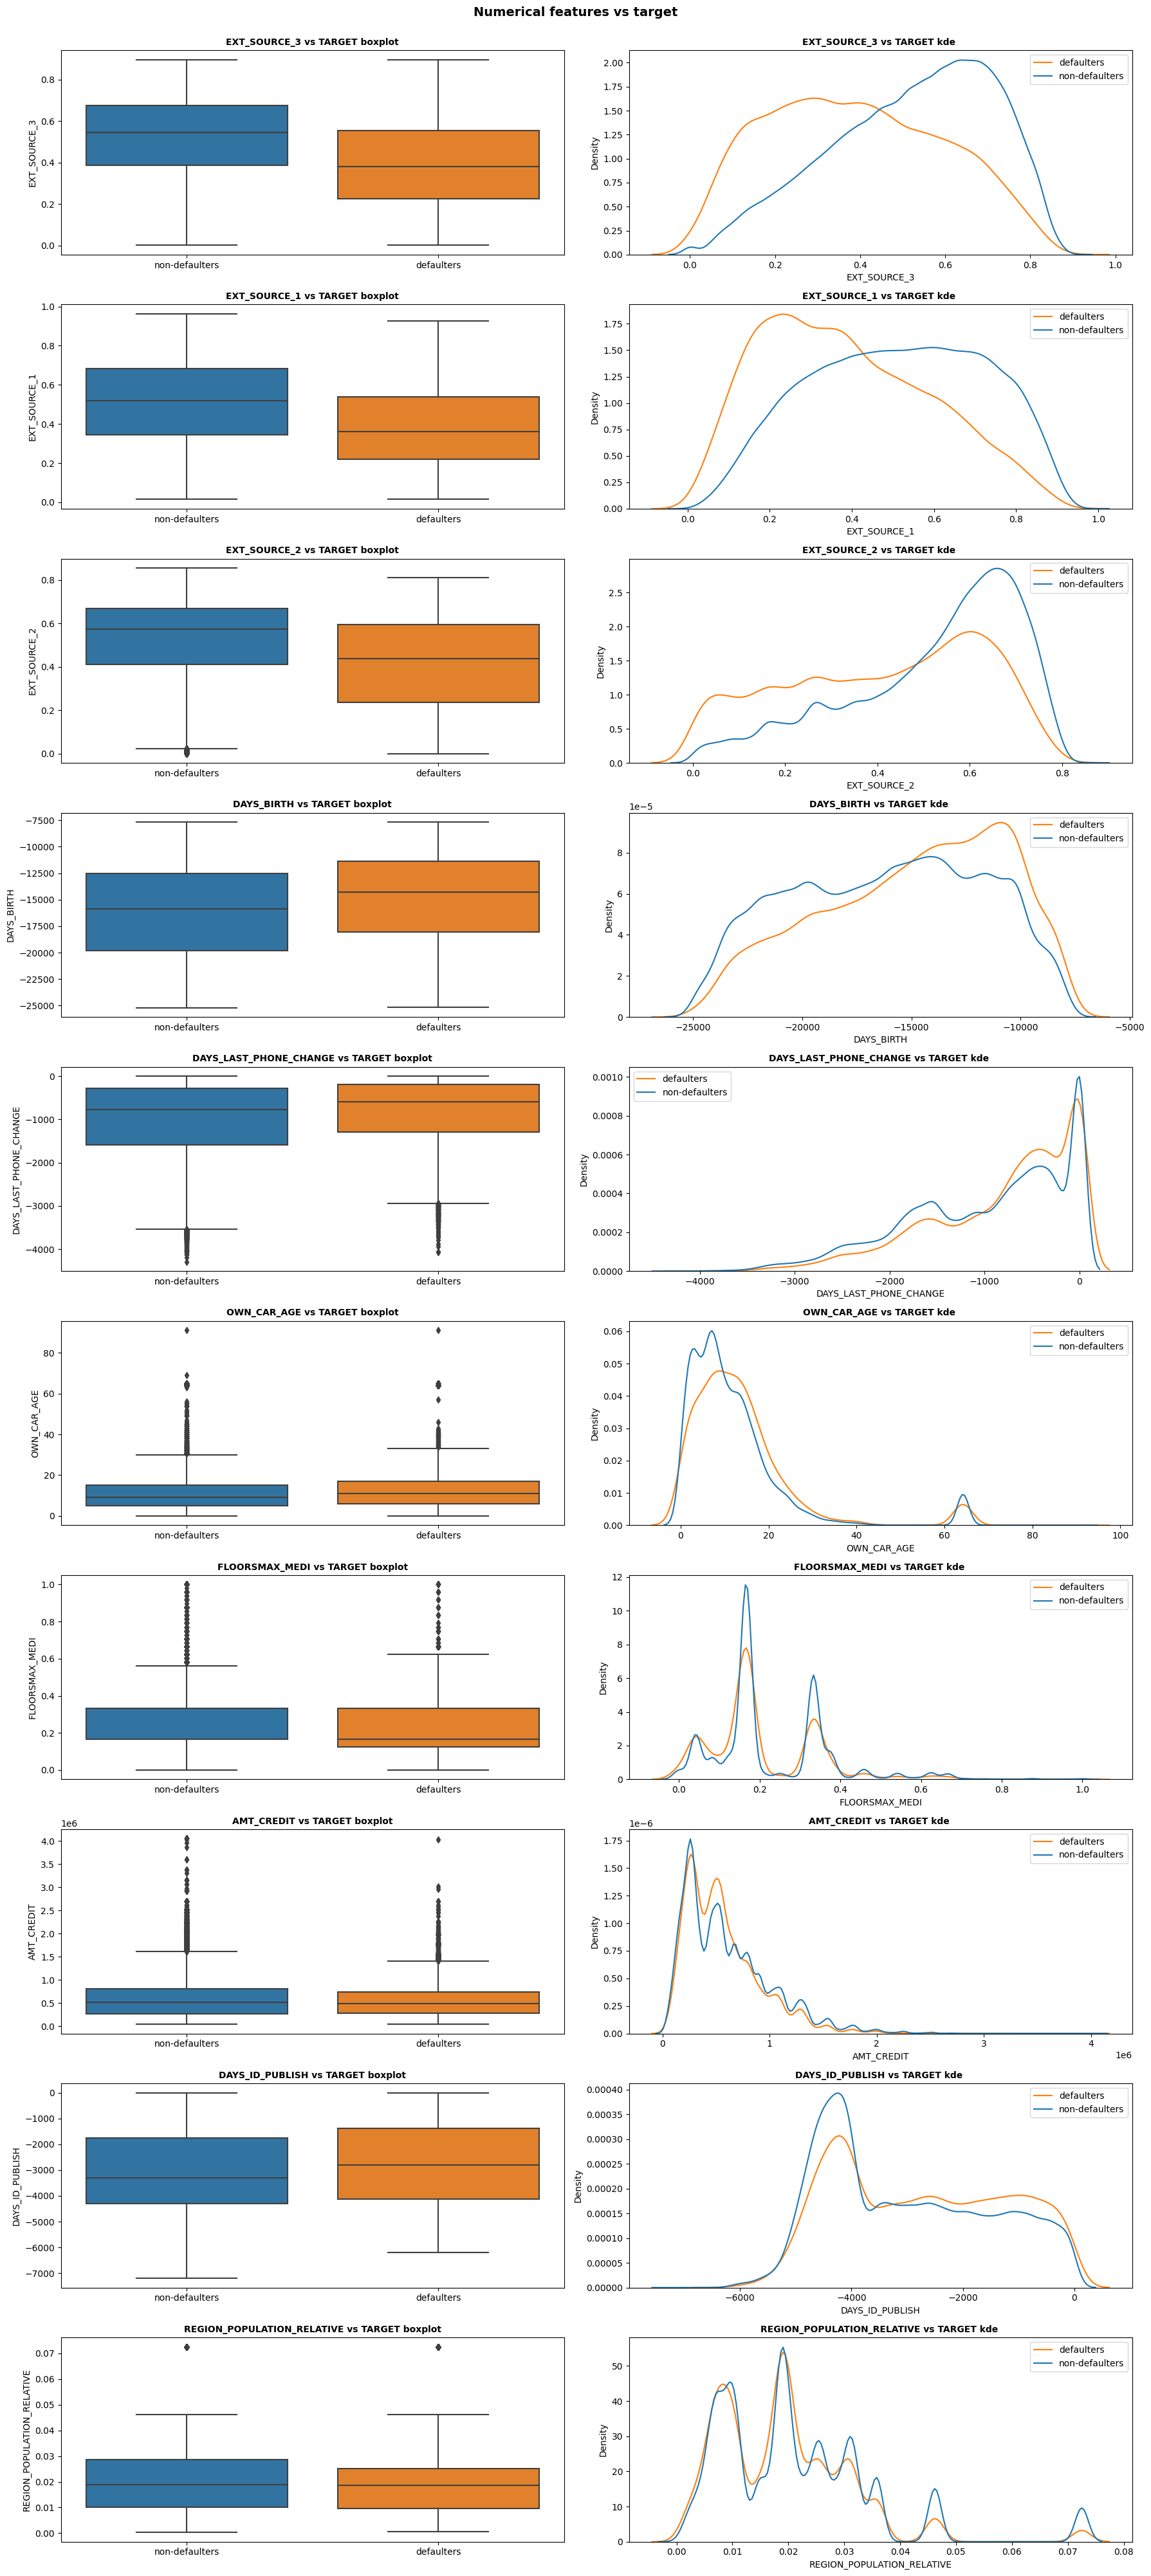

In [22]:
plot_num(df_eda, 'TARGET', num_col_plot, ['non-defaulters', 'defaulters'])

Observations:
* Average normalized scores from external data source for defaulters are lower than for non-defaulters by more than 0.1 of normalized values.
* Distribution of populations where the client lives shows skewedness toward more populated areas for both defaulters and non-defaulters. Proportionally defaulters live in less populated areas than non-defaulters.
* Distribution for both defaulters and non defaulters of amount of credit is skewed toward highier values with the average of 0.5 mln. The tail of distribution for non defaulters is thicker.
* As there is more non-defaulters we would expect more observations of defaulted by 60 days past due day from surrounding. One client has 24 people in the surrounding that defaulted in last 60 days in realtion to application. 
* The average age of owned car is lower for non-defaulters. Some clients have over 60 years old cars.
* Standard deviation of median of the maximal number of floors is highier for defaulters.
* The distribution of time for defaulters and non-defaulters was comparable.
* Non-defaulters had more outliers with high number of children under care.
* Distribution of number of elevator has thicker tail for defaulters in comparison with non-defaultes.
* In the last year before the application defaulters had more enquiries  to Credit Bureau on average.
* Defaulters are on average younger, had their ID replaced later and their last phone changed later than non-defaulters.

### EDA of categorical variables: 
* checking significance of correlations with target with chi-square test, 
* removing features that are correlated with each other based on spearman correlation,
* checking correlations with phik test,
* plotting a number of features with highiest correlations.

#### Checking significance of correlations with target with chi-square test

In [39]:
# Getting categorical features that are correlated to the target
categorical = corr_check_cat_cat(df_eda, 'TARGET', cat_col)

----------------------------------------------------------------------------------------------------
The columns that are correlated with target column: ['OCCUPATION_TYPE', 'NAME_INCOME_TYPE', 'REGION_RATING_CLIENT', 'NAME_EDUCATION_TYPE', 'CODE_GENDER', 'REG_CITY_NOT_WORK_CITY', 'FLAG_EMP_PHONE', 'ORGANIZATION_TYPE', 'REG_CITY_NOT_LIVE_CITY', 'FLAG_DOCUMENT_3', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'FLAG_WORK_PHONE', 'FLAG_DOCUMENT_6', 'FLAG_PHONE', 'WALLSMATERIAL_MODE', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'HOUSETYPE_MODE', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_18', 'NAME_TYPE_SUITE', 'REG_REGION_NOT_WORK_REGION', 'FONDKAPREMONT_MODE', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_15', 'REG_REGION_NOT_LIVE_REGION', 'FLAG_DOCUMENT_21']
----------------------------------------------------------------------------------------------------


In [24]:
print(f"The number of categorical features that weren't correlated with the target: {len(cat_col) - len(categorical)}")

The number of categorical features that weren't correlated with the target: 18


#### Removing features that are correlated with each other based on Spearman correlation

Now let's check which categorical features can be easily encoded. For this reason we will check the unique values of columns correlated to target.

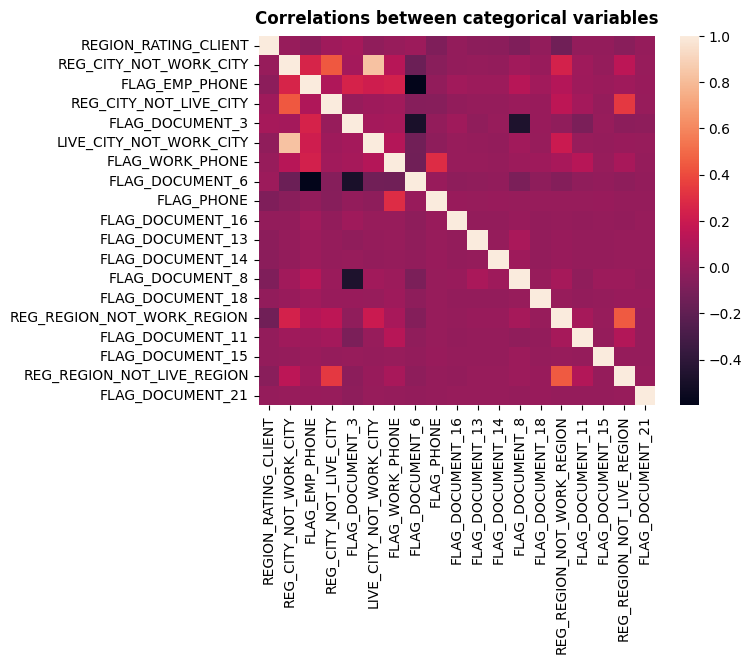

In [25]:
# Checking the correlations between categorical features
sns.heatmap(df_eda[categorical].corr(method='spearman'))
plt.title("Correlations between categorical variables", fontweight='bold', y=1.01);

We can see that some of the features are correlated with each other. Tne columns to consider are: REG_CITY_NOT_WORK_CITY and REG_CITY_NOT_LIVE_CITY. Let's remove the latest from the categorical columns list.

In [40]:
categorical.remove('REG_CITY_NOT_LIVE_CITY')
categorical.remove('LIVE_CITY_NOT_WORK_CITY')

#### Checking correlations with phik test

In [41]:
df_corr_cat = target_top_corr(df_eda, 'TARGET', categorical, numerical=False)
df_corr_cat

,phik_correlation
OCCUPATION_TYPE,0.10
CODE_GENDER,0.09
NAME_INCOME_TYPE,0.08
REG_CITY_NOT_WORK_CITY,0.08
FLAG_EMP_PHONE,0.07
FLAG_DOCUMENT_3,0.07
ORGANIZATION_TYPE,0.07
NAME_FAMILY_STATUS,0.05
NAME_HOUSING_TYPE,0.05
NAME_EDUCATION_TYPE,0.05


In [42]:
cat_col_plot = df_corr_cat.index.to_list()

#### Displaying meaning of categorical columns with highiest correlations to target

In [35]:
names.loc[(names['Table']=='application_{train|test}.csv')&(names['Row'].isin(cat_col_plot))][['Row', 'Description', 'Special']]

,Row,Description,Special
6,CODE_GENDER,Gender of the client,NaN
15,NAME_INCOME_TYPE,"Clients income type (businessman, working, maternity leave, )",NaN
17,NAME_FAMILY_STATUS,Family status of the client,NaN
18,NAME_HOUSING_TYPE,"What is the housing situation of the client (renting, living with parents, ...)",NaN
26,FLAG_EMP_PHONE,"Did client provide work phone (1=YES, 0=NO)",NaN
31,OCCUPATION_TYPE,What kind of occupation does the client have,NaN
41,REG_CITY_NOT_WORK_CITY,"Flag if client's permanent address does not match work address (1=different, 0=same, at city level)",NaN
42,LIVE_CITY_NOT_WORK_CITY,"Flag if client's contact address does not match work address (1=different, 0=same, at city level)",NaN
43,ORGANIZATION_TYPE,Type of organization where client works,NaN
100,FLAG_DOCUMENT_3,Did client provide document 3,NaN


#### Checking for missing values in features with highiest correlations

----------------------------------------------------------------------------------------------------
Number of columns in Missing values in categorical columns with highiest correlation to target: 10 columns
Number of columns with missing values in Missing values in categorical columns with highiest correlation to target: 3 columns
----------------------------------------------------------------------------------------------------


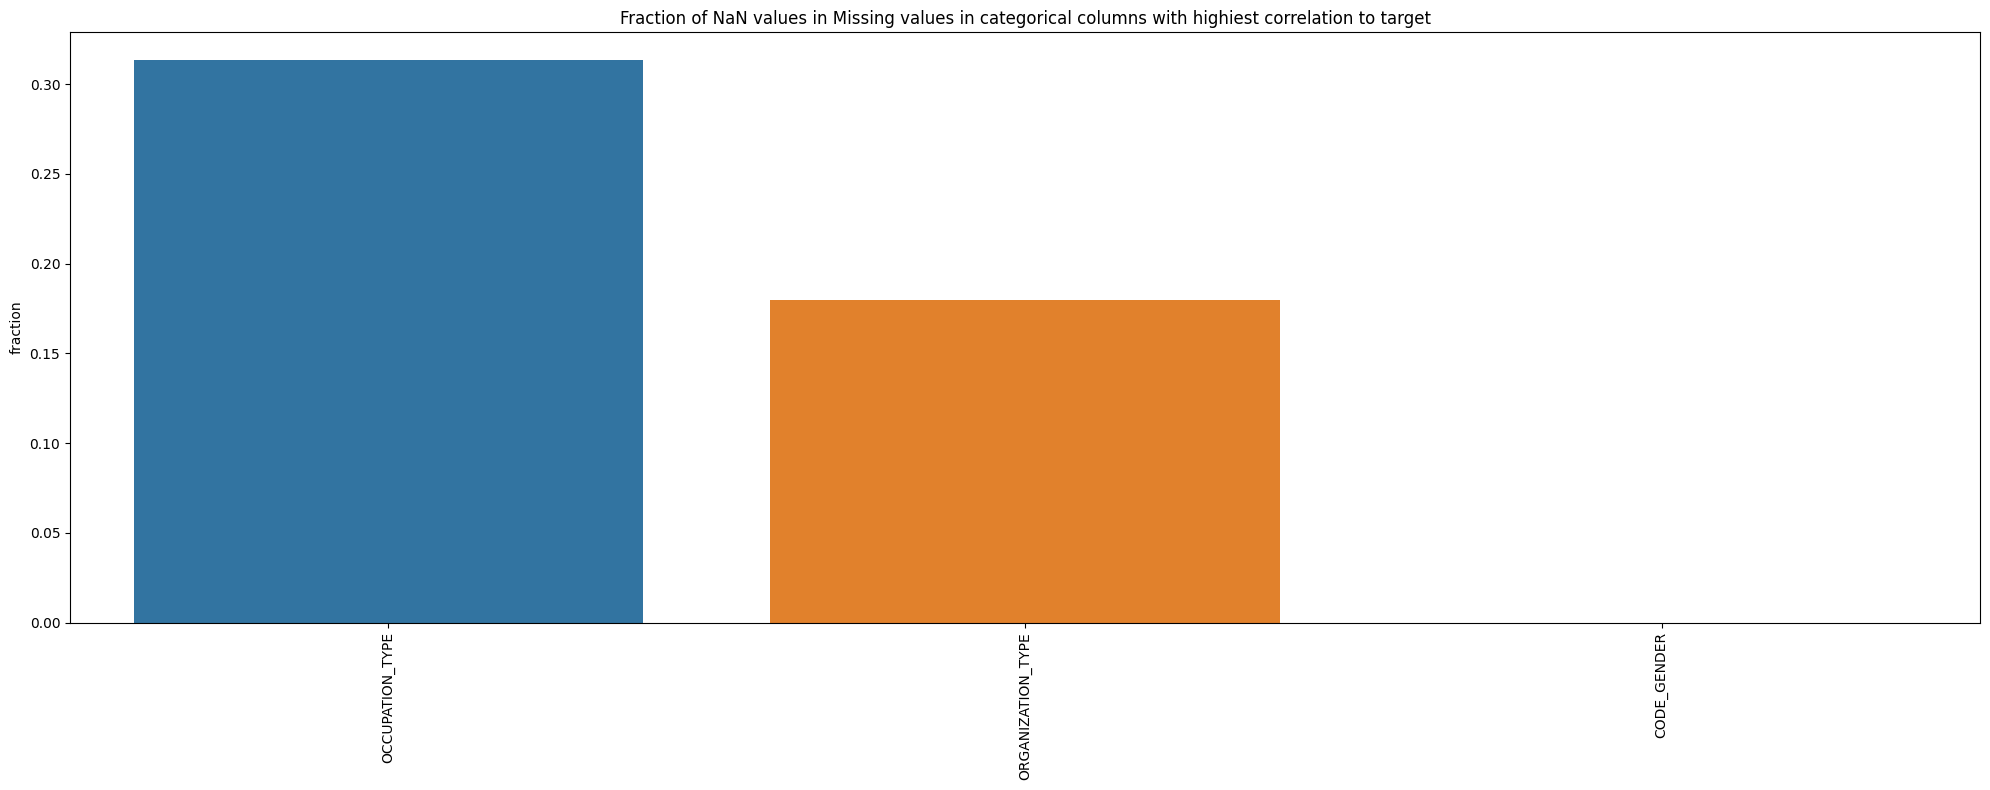

In [36]:
plot_missing(df_eda[cat_col_plot], 'Missing values in categorical columns with highiest correlation to target')

#### Plotting categorical features with highiest correlation vs target variable

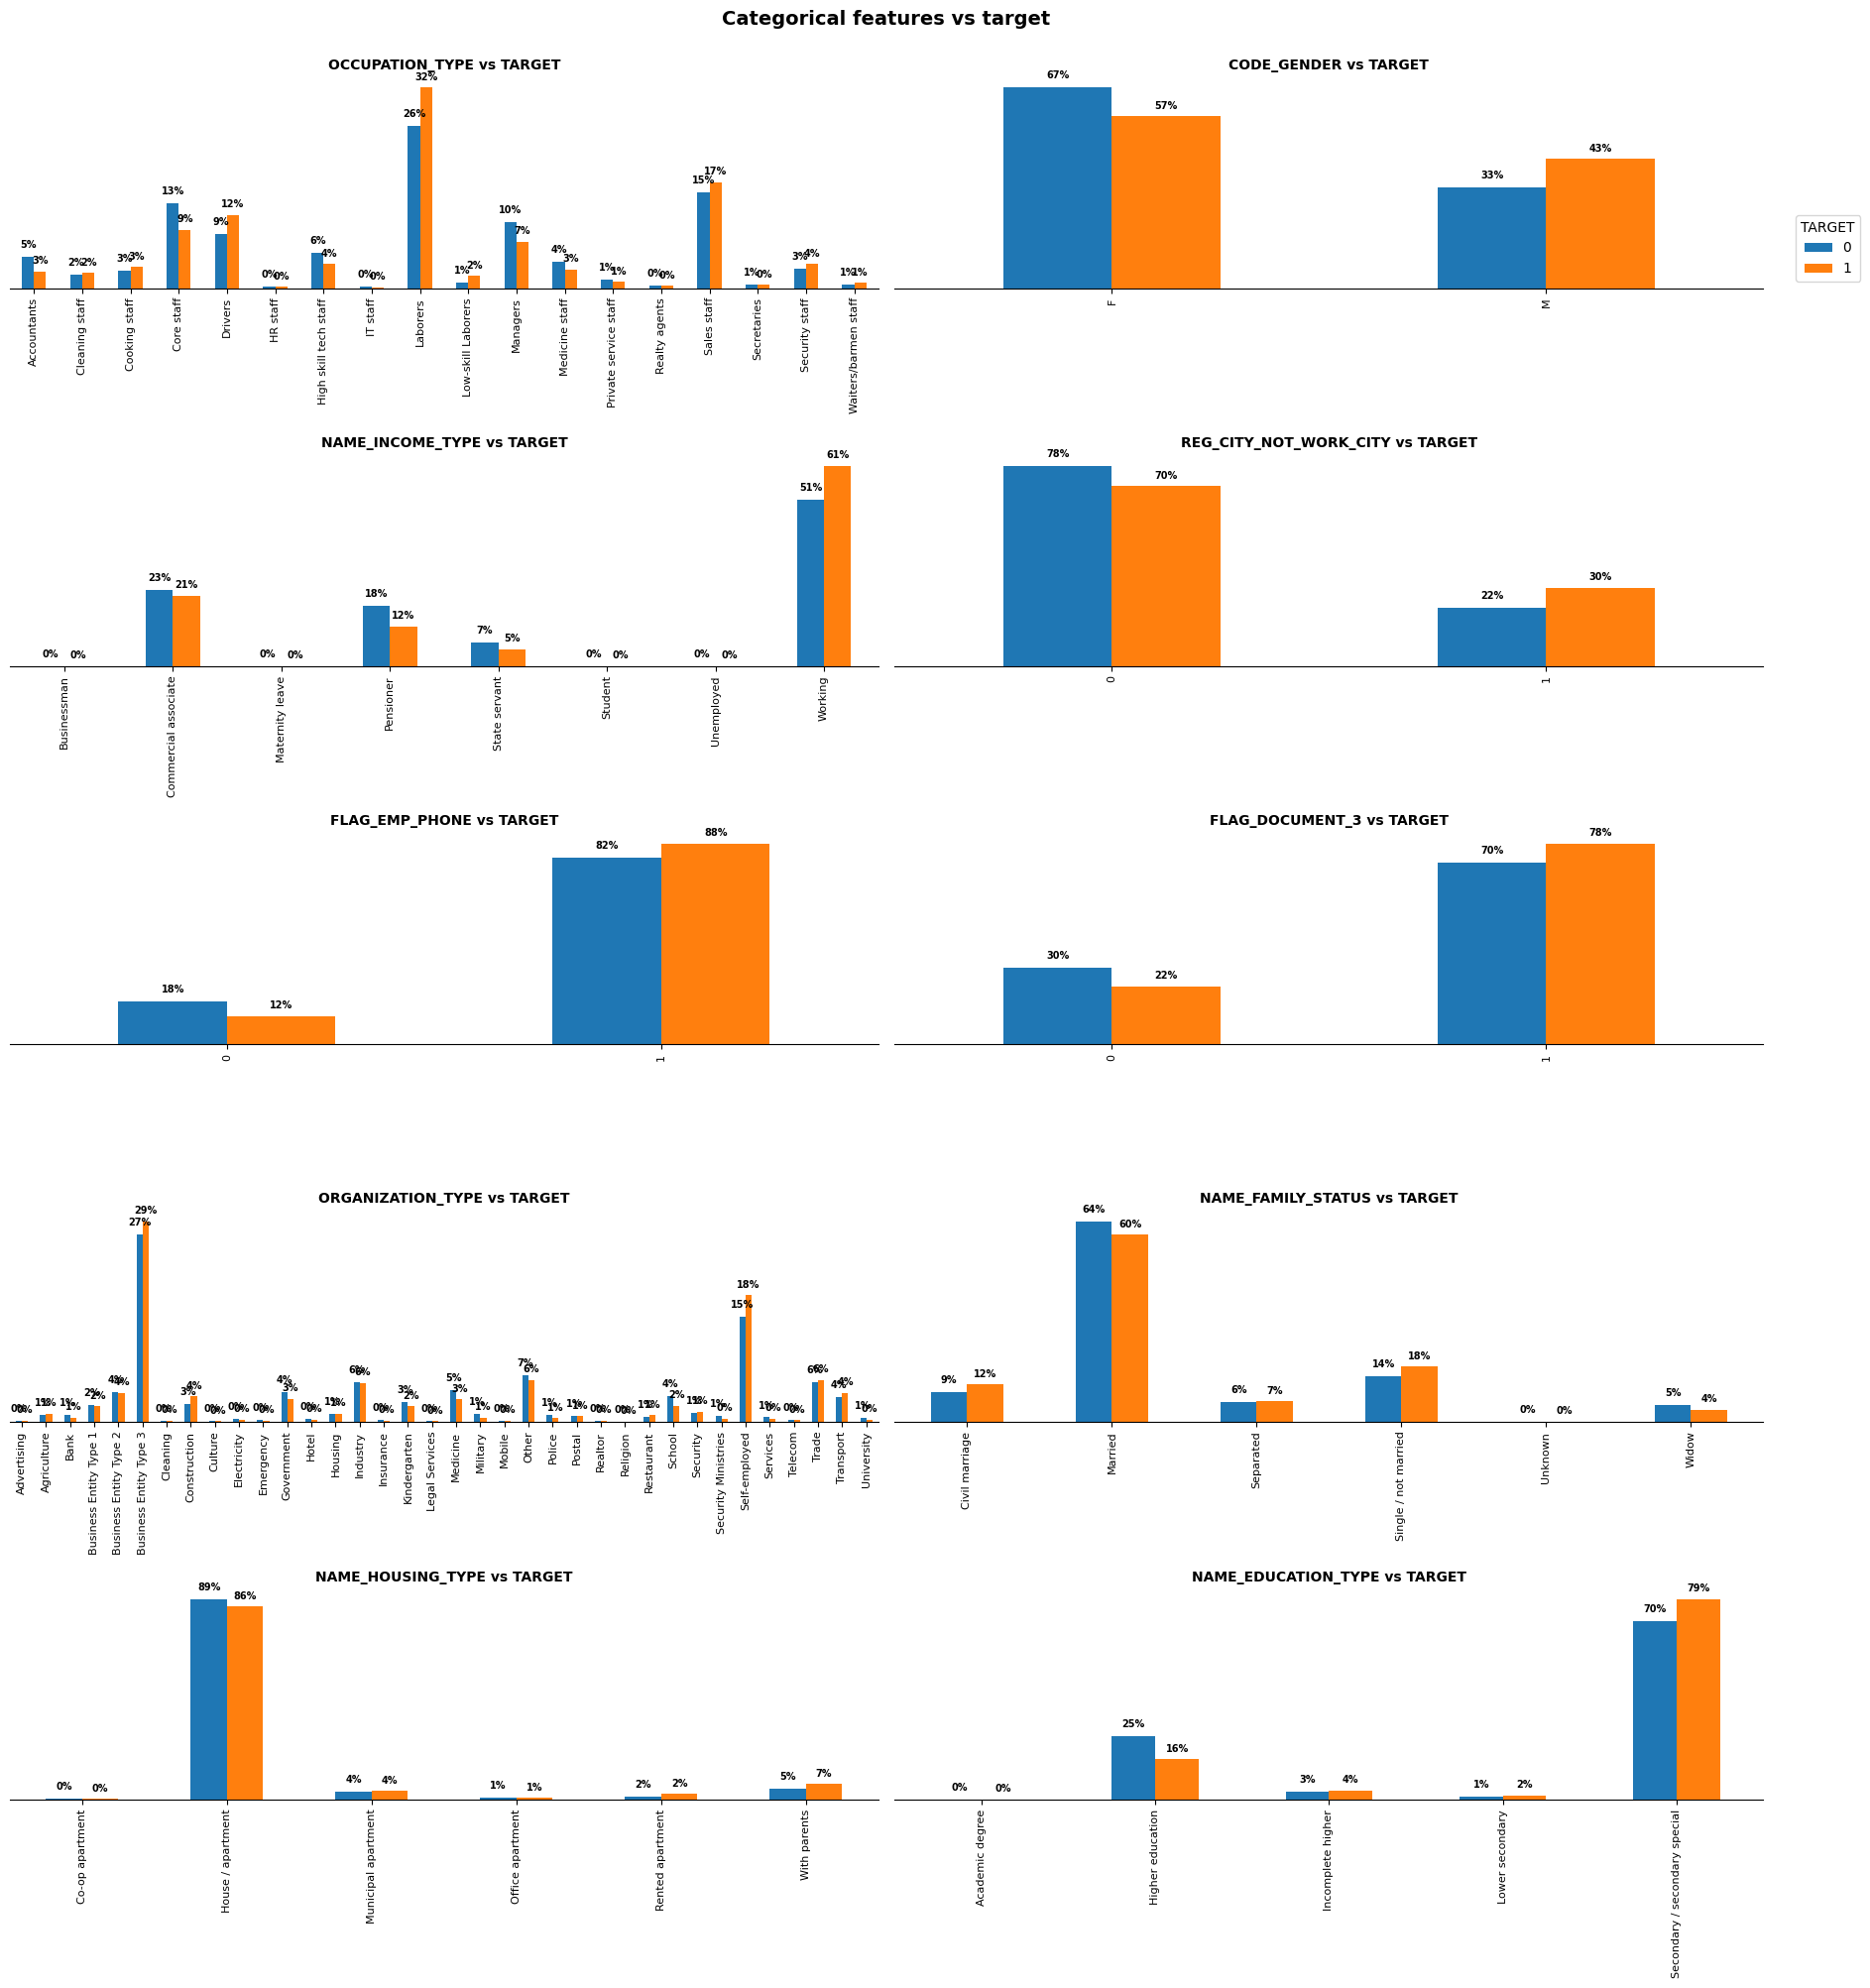

In [43]:
plot_cat_bars(df_eda, 'TARGET', cat_col_plot)

Observations:
* There are more defaulters among self-employed and business entry type 3. This column may be important in predicting in someone may have problems with credit repayment. 
* There are more defaulters in occupations like laborers, sales staff, drivers but less in occupations like medicine staff, managers, core staff and high skill tech staff.
* People with income from working default more than pensioners, state_servants and commercial associate.
* Clients from region with rating 3 default more than from regions with rating 1 and 2.
* People with lower level of education default more often.
* Fraction of male is highier in defaulting group which may suggest that the probability for defaulting for male is highier. More females take credits.
* More defaulters are flagged with permanent address not matching work address at the city level. They may commute to work, not being able to live in a city with highier life expences.
* More defaulters gave their employment phone where one of the theories could be their avoidance in contacting them.
* Defualters has been flagged more often as the once where permanent address and the city they lived in was different.
* More defaulters provided document 3 in comparison with non-defaulters.
* Singles and clients in civil marriage defaulted more often than married and widowed. Married were taking the credits most often.
* Clients taht live with parents or rent are more prone to default in comparison with people who live in house or appartment. The highiest number of loans were given to people with living in the house.
* More people who lived in different city than worked were defaulting although tha majority of people living in the same place were given the credits.
* Cash loans were more risky for the bank than revolving loans.
* Document 6 was delivered less often by defaulters.
* Defaulters provided their phone number less often.
* Defaulters had a car less often than non-defaulters. Most clients don't own a car.
* People living in accomodation made of wood, stone and brick defaulted more than from other materials.
* People who were living unaccompanied were more likely to default. They were also the majority of clients.
* Most defaulters didn't own a flat or house.

## bureau.csv

Contains infomation from Credit Bureau about all credits taken by applicants from application_train.csv and application_train.

### Loading data

In [71]:
bureau = pd.read_csv("bureau.csv")
bureau.head(2)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.00,-153.00,NaN,0,"91,323.00",0.00,NaN,0.00,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,"1,075.00",NaN,NaN,0,"225,000.00","171,342.00",NaN,0.00,Credit card,-20,NaN


### Reducing memory usage

In [73]:
# Removing duplicates
bureau = duplicates_check(bureau, 'bureau.csv')

# Reducing memory
bureau = reduce_memory_usage(bureau)

----------------------------------------------------------------------------------------------------
bureau.csv had 0 rows removed
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int32  
 1   SK_ID_BUREAU            int32  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int16  
 5   CREDIT_DAY_OVERDUE      int16  
 6   DAYS_CREDIT_ENDDATE     float32
 7   DAYS_ENDDATE_FACT       float32
 8   AMT_CREDIT_MAX_OVERDUE  float32
 9   CNT_CREDIT_PROLONG      int8   
 10  AMT_CREDIT_SUM          float32
 11  AMT_CREDIT_SUM_DEBT     float32
 12  AMT_CREDIT_SUM_LIMIT    float32
 13  AMT_CREDIT_SUM_OVERDUE  float32
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE   

### Splitting data

For eda we will merge the target variable with all unique values of SK_ID_CURR from last eda set. Those were stored in app_id_eda variable

In [160]:
# Merging bureau table with target variable and extracting data for analysis
bureau_eda = df[['SK_ID_CURR', 'TARGET']].loc[df['SK_ID_CURR'].isin(app_id_eda)].merge(bureau, on='SK_ID_CURR', how='inner')
bureau_eda.head()

,SK_ID_CURR,TARGET,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,100002,1,6158904,Closed,currency 1,-1125,0,"-1,038.00","-1,038.00",NaN,0,"40,761.00",NaN,NaN,0.00,Credit card,-1038,0.00
1,100002,1,6158905,Closed,currency 1,-476,0,NaN,-48.00,NaN,0,0.00,0.00,NaN,0.00,Credit card,-47,NaN
2,100002,1,6158906,Closed,currency 1,-1437,0,"-1,072.00","-1,185.00",0.00,0,"135,000.00",0.00,0.00,0.00,Consumer credit,-1185,0.00
3,100002,1,6158907,Closed,currency 1,-1121,0,-911.00,-911.00,"3,321.00",0,"19,071.00",NaN,NaN,0.00,Consumer credit,-906,0.00
4,100002,1,6158908,Closed,currency 1,-645,0,85.00,-36.00,"5,043.65",0,"120,735.00",0.00,0.00,0.00,Consumer credit,-34,0.00


In [87]:
print(f'Number of credits provided by the bureau: {bureau_eda.shape[0]}')
print(f'Number of unique applications: {len(app_id_eda)}')
print(f'Number of overlapping SK_ID_CURR: {len(bureau_eda["SK_ID_CURR"].unique())}')
print(f"Number of applications without previous credits: {len(set(app_id_eda)) - len(bureau_eda['SK_ID_CURR'].unique())}")

Number of credits provided by the bureau: 1172822
Number of unique applications: 246008
Number of overlapping SK_ID_CURR: 210831
Number of applications without previous credits: 35177


### Plotting target variable

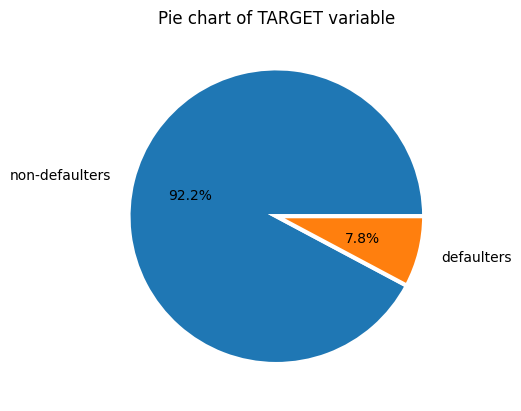

In [89]:
pie_plot(bureau_eda, 'TARGET', ['non-defaulters', 'defaulters'])

In the group with clients who already had previous record in credit bureau the number of defaulters in lower or clients who didn't defaulted had highier probablity of getting more credits. Let's check that.

In [106]:
# Aggregating data with the count of taken credits
count_credits = bureau_eda[['SK_ID_CURR', 'TARGET', "SK_ID_BUREAU"]].groupby(['SK_ID_CURR', 'TARGET'])['SK_ID_BUREAU'].count()
count_credits = count_credits.to_frame().reset_index().rename(columns={'SK_ID_BUREAU': 'CREDITS_TAKEN'})

In [108]:
# Crosstab of defaulting and numbers of records in credit bureau
pd.crosstab(index=count_credits['TARGET'], columns=count_credits['CREDITS_TAKEN']).apply(lambda x: x/sum(x), axis=1)

CREDITS_TAKEN,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,47,48,49,50,51,52,53,54,55,56,59,61,94,116
TARGET,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.14,0.14,0.13,0.11,0.09,0.08,0.07,0.05,0.04,0.03,0.03,0.02,0.02,0.01,0.01,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.15,0.14,0.12,0.10,0.09,0.07,0.06,0.05,0.04,0.03,0.03,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


We can see that defaulters have a bit highier fraction of one credit while non-defaulters have more records with between 3 and 7 credits taken. This feature can have predictive power when we get to modelling. 

In [110]:
# Let's store the bureau id and remove columns that are not needed for analysis
bureau_id_eda = bureau_eda['SK_ID_BUREAU'].unique()

### Categorizing columns

In [126]:
# Categorical columns that are of object type
object_col = get_object_columns(bureau_eda, 'TARGET')

# Categorical features that are encoded
encoded_col = get_cat_encoded_columns(bureau_eda, 'TARGET')

# All categorical features
cat_col = object_col + encoded_col

# Numerical continuous variables
num_col = get_num_col(bureau_eda, encoded_col, 'TARGET', ordinal_col)
num_col.remove('SK_ID_CURR')
num_col.remove('SK_ID_BUREAU')

### EDA of continuous features

#### Checking the significance of correlations with target with anova test

In [112]:
# Getting columns that are correlated with target 
numerical_corr = corr_check_num_cat(bureau_eda, 'TARGET', num_col)

----------------------------------------------------------------------------------------------------
The columns that are correlated with target column: ['DAYS_CREDIT', 'AMT_CREDIT_MAX_OVERDUE', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_ANNUITY', 'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE', 'DAYS_CREDIT_ENDDATE', 'CREDIT_DAY_OVERDUE', 'DAYS_ENDDATE_FACT', 'CNT_CREDIT_PROLONG']
----------------------------------------------------------------------------------------------------


In [113]:
print(f'Number of numerical columns that are not correlated with target: {len(num_col) - len(numerical_corr)}')

Number of numerical columns that are not correlated with target: 1


#### Inspecting and removing multicollinear features

In [114]:
# Displaying Pearson correlations between numerical features correlated to target variable
df_pearson = bureau_eda[numerical_corr]
pearson_corr_df(df_pearson)

,DAYS_CREDIT,AMT_CREDIT_MAX_OVERDUE,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_ANNUITY,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,DAYS_CREDIT_ENDDATE,CREDIT_DAY_OVERDUE,DAYS_ENDDATE_FACT
DAYS_CREDIT,1.00,-0.01,0.14,0.02,0.00,-0.00,0.69,0.23,-0.03,0.88
AMT_CREDIT_MAX_OVERDUE,-0.01,1.00,0.02,0.00,0.00,0.01,-0.00,0.00,0.00,0.00
AMT_CREDIT_SUM_DEBT,0.14,0.02,1.00,-0.02,0.02,0.01,0.15,0.09,-0.00,0.02
AMT_CREDIT_SUM_LIMIT,0.02,0.00,-0.02,1.00,0.00,-0.00,0.04,0.09,-0.00,0.02
AMT_ANNUITY,0.00,0.00,0.02,0.00,1.00,0.00,0.00,0.00,-0.00,0.00
AMT_CREDIT_SUM_OVERDUE,-0.00,0.01,0.01,-0.00,0.00,1.00,0.00,0.00,0.10,-0.00
DAYS_CREDIT_UPDATE,0.69,-0.00,0.15,0.04,0.00,0.00,1.00,0.25,-0.02,0.75
DAYS_CREDIT_ENDDATE,0.23,0.00,0.09,0.09,0.00,0.00,0.25,1.00,-0.01,0.25
CREDIT_DAY_OVERDUE,-0.03,0.00,-0.00,-0.00,-0.00,0.10,-0.02,-0.01,1.00,-0.01
DAYS_ENDDATE_FACT,0.88,0.00,0.02,0.02,0.00,-0.00,0.75,0.25,-0.01,1.00


We see that 3 features are correlated with each other. We will remove DAYS_ENDDATE_FACT.

In [115]:
# Assigning not correlated features to numerical
numerical_corr.remove('DAYS_ENDDATE_FACT')
numerical = numerical_corr

#### Checking correlations with target using phik, spearman and pearson test

In [116]:
df_corr_num = target_top_corr(bureau_eda, 'TARGET', numerical)
df_corr_num

,phik_correlation,phik_abs_correlation,spearman_correlation,pearson_correlation
DAYS_CREDIT,0.09,0.09,0.07,0.06
DAYS_CREDIT_ENDDATE,0.02,0.02,0.05,0.03
AMT_CREDIT_MAX_OVERDUE,0.01,0.01,0.03,0.00
AMT_CREDIT_SUM_OVERDUE,0.01,0.01,0.02,0.01
AMT_CREDIT_SUM_LIMIT,0.01,0.01,0.02,-0.01
AMT_CREDIT_SUM_DEBT,0.00,0.00,0.04,0.00
CNT_CREDIT_PROLONG,0.00,0.00,0.00,0.00
CREDIT_DAY_OVERDUE,0.00,0.00,0.02,0.00
DAYS_CREDIT_UPDATE,0.00,0.00,0.05,0.04
AMT_ANNUITY,0.00,0.00,0.03,0.00


From the dataframe we see that the correlations are quite week. We will choose the strongest correlated columns for further analysis.

In [119]:
# Columns with highiest correlations
num_col_plot = ['DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'AMT_CREDIT_SUM_DEBT', 'DAYS_CREDIT_UPDATE']

#### Display meaning of continuous variables which are correlated to target

In [123]:
names.loc[(names['Table']=='bureau.csv')&(names['Row'].isin(num_col_plot))][['Row', 'Description', 'Special']]

,Row,Description,Special
129,DAYS_CREDIT,How many days before current application did client apply for Credit Bureau credit,time only relative to the application
131,DAYS_CREDIT_ENDDATE,Remaining duration of CB credit (in days) at the time of application in Home Credit,time only relative to the application
136,AMT_CREDIT_SUM_DEBT,Current debt on Credit Bureau credit,NaN
140,DAYS_CREDIT_UPDATE,How many days before loan application did last information about the Credit Bureau credit come,time only relative to the application


#### Checking for missing values in features with highiest correlations

----------------------------------------------------------------------------------------------------
Number of columns in Missing values in numerical columns with highiest correlation to target: 4 columns
Number of columns with missing values in Missing values in numerical columns with highiest correlation to target: 2 columns
----------------------------------------------------------------------------------------------------


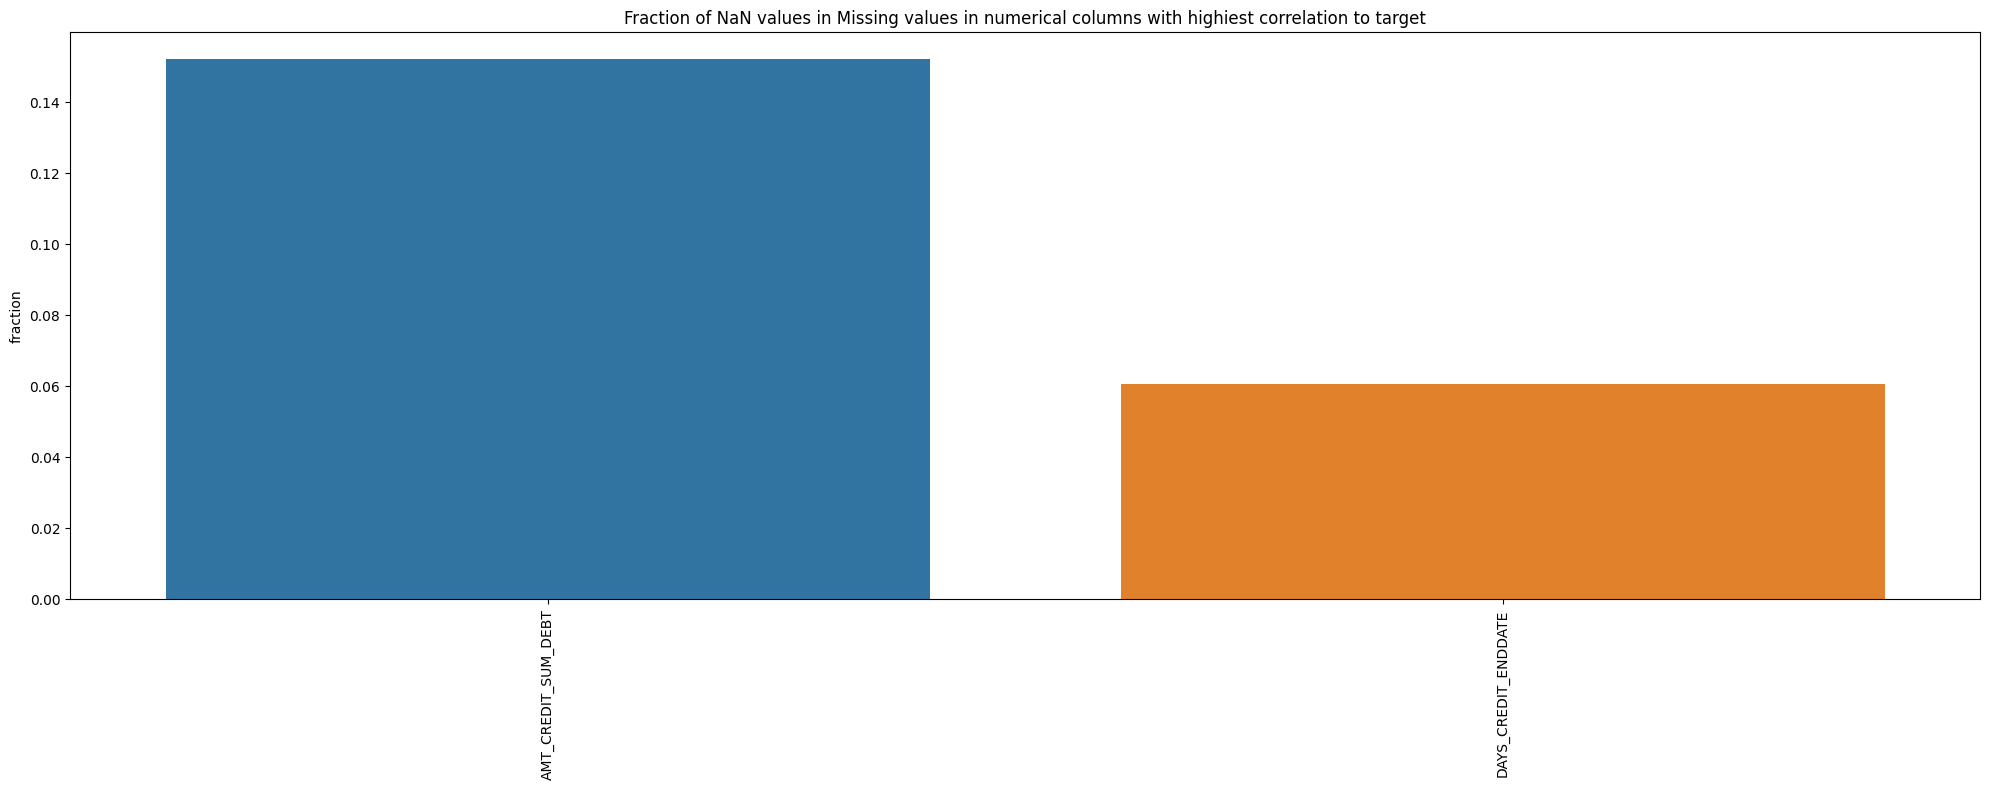

In [120]:
plot_missing(bureau_eda[num_col_plot], 'Missing values in numerical columns with highiest correlation to target')

#### Plotting continuous variables which are correlated with the target

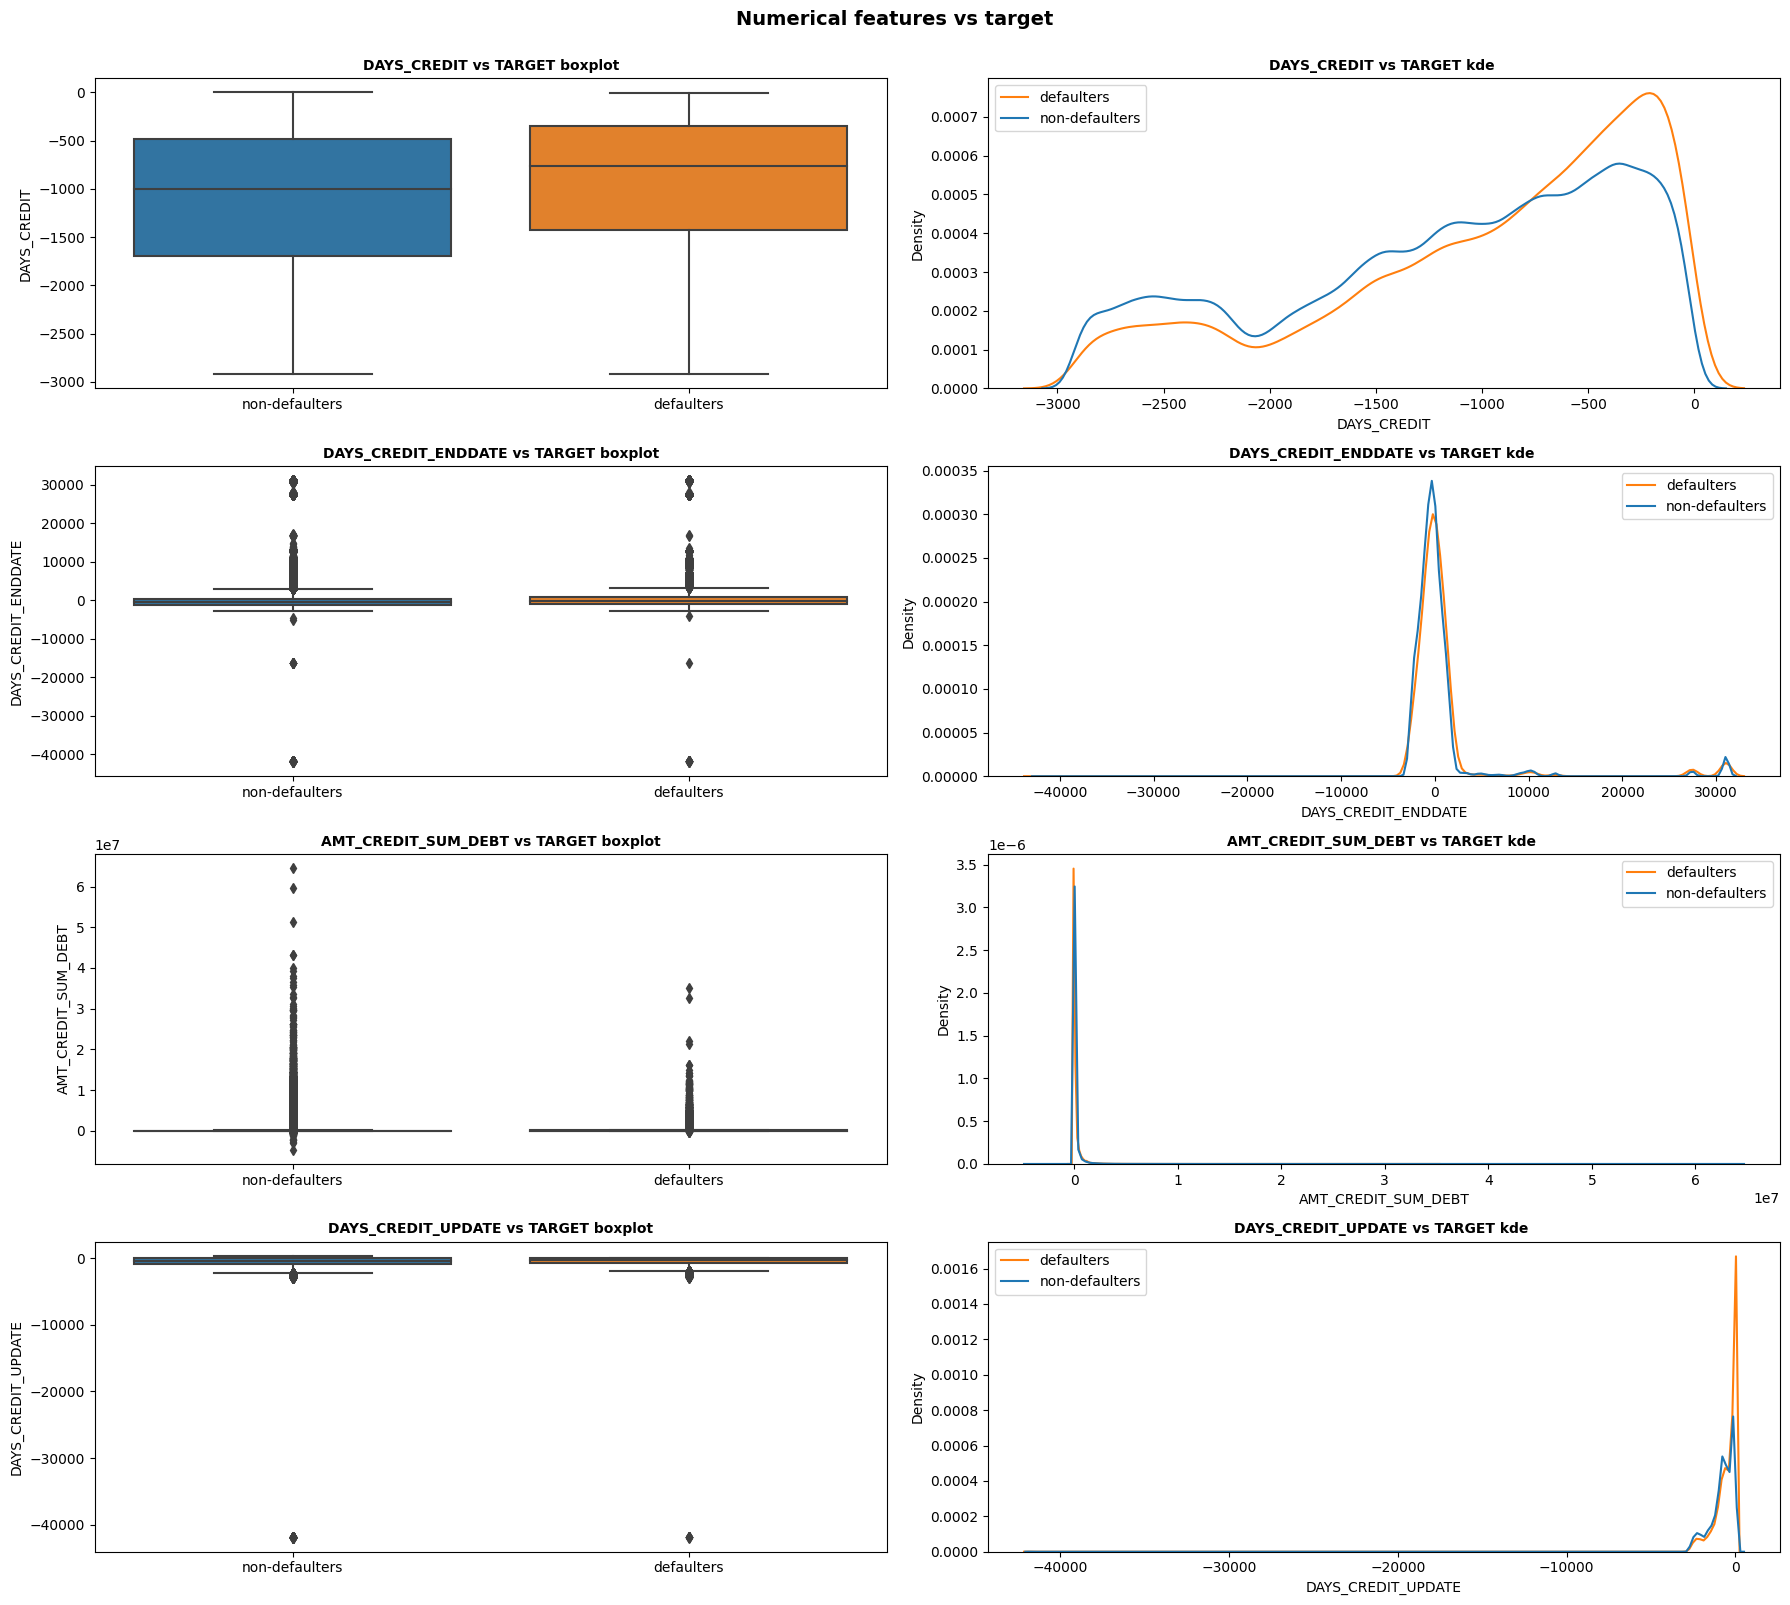

In [122]:
plot_num(bureau_eda, 'TARGET', num_col_plot, ['non-defaulters', 'defaulters'])

Observations:
* On average defaulters applied less days for credit from credit bureau than non-defaulters.
* The entries from days of last credit enddate doesn't seem to have much sense and they would suggest credits with the end date in 100 years. From the kde we see that the mean value for defaulters is bigger than for non-defaulter. Defaulters may already have active credit.
* Non-defaulters are skweeded to the right with the current debt in credit bureau.
* Some values in last credit update suggests updates more than 100 yrs ago which seems not to be right. For defaulters the updates are closer to the date of aplication.
* The values over 60 yrs will be removed as those seems to be some kind of error.

### EDA of categorical variables: 

#### Checking columns the significant correlations with target with chi_square test

In [127]:
# Getting categorical features that are correlated to the target
categorical = corr_check_cat_cat(bureau_eda, 'TARGET', cat_col)

----------------------------------------------------------------------------------------------------
The columns that are correlated with target column: ['CREDIT_ACTIVE', 'CREDIT_TYPE', 'CREDIT_CURRENCY']
----------------------------------------------------------------------------------------------------


In [128]:
print(f"The number of categorical features that weren't correlated with the target: {len(cat_col) - len(categorical)}")

The number of categorical features that weren't correlated with the target: 0


#### Checking correlations with phik test

In [134]:
df_corr_cat = target_top_corr(bureau_eda, 'TARGET', categorical, numerical=False)
df_corr_cat

,phik_correlation
CREDIT_ACTIVE,0.07
CREDIT_TYPE,0.05
CREDIT_CURRENCY,0.01


We see that the currency of the credit is only slightly correlated with the target. We won't plot this.

In [135]:
cat_col_plot = ['CREDIT_ACTIVE', 'CREDIT_TYPE']

#### Displaying meanings of columns of interest

In [136]:
names.loc[(names['Table']=='bureau.csv')&(names['Row'].isin(cat_col_plot))][['Row', 'Description', 'Special']]

,Row,Description,Special
127,CREDIT_ACTIVE,Status of the Credit Bureau (CB) reported credits,NaN
139,CREDIT_TYPE,"Type of Credit Bureau credit (Car, cash,...)",NaN


#### Displaying fractions of categorical features with highiest correlations to target

As there are only two we will check them one by one.

In [150]:
# Credit active fractions
pd.crosstab(bureau_eda['TARGET'], bureau_eda['CREDIT_ACTIVE']).apply(lambda x: x/sum(x), axis=1)

CREDIT_ACTIVE,Active,Bad debt,Closed,Sold
TARGET,,,,
0,0.36,0.00,0.63,0.00
1,0.44,0.00,0.55,0.01


In [151]:
# Credit type fractions
pd.crosstab(bureau_eda['TARGET'], bureau_eda['CREDIT_TYPE']).apply(lambda x: x/sum(x), axis=1)

CREDIT_TYPE,Another type of loan,Car loan,Cash loan (non-earmarked),Consumer credit,Credit card,Interbank credit,Loan for business development,Loan for purchase of shares (margin lending),Loan for the purchase of equipment,Loan for working capital replenishment,Microloan,Mobile operator loan,Mortgage,Real estate loan,Unknown type of loan
TARGET,,,,,,,,,,,,,,,
0,0.00,0.02,0.00,0.73,0.23,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.00
1,0.00,0.01,0.00,0.70,0.26,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.01,0.00,0.00


Observations:
* There is more clossed possitions in general but for defaulters they have more active credits, 1% of defaulters had sold credit in the past.
* The highiest number of credits are consumer credits. There are more defaults on credit cards. 

### bureau_balance.csv

Contains monthly balances of credits in credit bureau.

#### Loading data

In [153]:
bureau_balance = pd.read_csv("bureau_balance.csv")
bureau_balance.head(2)

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C


In [154]:
bureau_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


#### Reducing memory usage

In [157]:
bureau_balance = reduce_memory_usage(bureau_balance)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int32 
 1   MONTHS_BALANCE  int8  
 2   STATUS          object
dtypes: int32(1), int8(1), object(1)
memory usage: 338.5+ MB
None


Again we were able to reduce memory usage by half.

#### Data for EDA

In [165]:
# Merging bureau table with target variable and extracting data for analysis
bureau_balance_eda = bureau_eda[['SK_ID_BUREAU', 'TARGET']].merge(bureau_balance, on='SK_ID_BUREAU', how='inner')
bureau_balance_eda.head()

,SK_ID_BUREAU,TARGET,MONTHS_BALANCE,STATUS
0,6158904,1,-15,C
1,6158904,1,-16,C
2,6158904,1,-17,0
3,6158904,1,-18,0
4,6158904,1,-19,0


In [175]:
print('-'*100)
print(f'Number of unique values in bureau_balance.csv for EDA: {len(bureau_balance_eda["SK_ID_BUREAU"].unique())}')
print(f'Number of entries in bureau_balance.csv for EDA: {bureau_balance.shape[0]}')
print('-'*100)
print(f'Unique values of STATUS are:\n{bureau_balance_eda.STATUS.unique()}')
print("")
print(f'Maximum number of repayment months: {np.abs(bureau_balance_eda["MONTHS_BALANCE"].min())}')
print('-'*100)

----------------------------------------------------------------------------------------------------
Number of unique values in bureau_balance.csv for EDA: 418948
Number of entries in bureau_balance.csv for EDA: 27299925
----------------------------------------------------------------------------------------------------
Unique values of STATUS are:
['C' '0' '1' 'X' '3' '2' '5' '4']

Maximum number of repayment months: 96
----------------------------------------------------------------------------------------------------


In [169]:
# Displaying 
names.loc[(names['Table']=='bureau_balance.csv')][['Row', 'Description', 'Special']]

,Row,Description,Special
142,SK_BUREAU_ID,Recoded ID of Credit Bureau credit (unique coding for each application) - use this to join to CREDIT_BUREAU table,hashed
143,MONTHS_BALANCE,Month of balance relative to application date (-1 means the freshest balance date),time only relative to the application
144,STATUS,"Status of Credit Bureau loan during the month (active, closed, DPD0-30, [C means closed, X means status unknown, 0 means no DPD, 1 means maximal did during month between 1-30, 2 means DPD 31-60, 5 means DPD 120+ or sold or written off ] )",NaN


#### Displaying fractions of credit status vs target

In [178]:
pd.crosstab(bureau_balance_eda['TARGET'], bureau_balance_eda['STATUS']).apply(lambda x: x/sum(x), axis=1)

STATUS,0,1,2,3,4,5,C,X
TARGET,,,,,,,,
0,0.31,0.01,0.00,0.00,0.00,0.00,0.48,0.19
1,0.34,0.02,0.00,0.00,0.00,0.00,0.44,0.20


Observations:
* There are 8 unique values for STATUS. 
* There are more closed creditlines for non-defaulters than defualters.
* There are more credits with unknown status, or pass due date for defaulters than for non-defaulters. Surprisingly still clients who didn't defaulted with the current application defaulted 31% of times with payment up to 30 days past due date. 

#### Checking if the features are correlated with the target:

* MONTHS_BALANCE anova test
* STATUS chi_square test

In [179]:
# Months balance correlation
corr_check_num_cat(bureau_balance_eda, 'TARGET', ['MONTHS_BALANCE'])

----------------------------------------------------------------------------------------------------
The columns that are correlated with target column: ['MONTHS_BALANCE']
----------------------------------------------------------------------------------------------------


['MONTHS_BALANCE']

In [180]:
# Status correlation with target
corr_check_cat_cat(bureau_balance_eda, 'TARGET', ['STATUS'])

----------------------------------------------------------------------------------------------------
The columns that are correlated with target column: ['STATUS']
----------------------------------------------------------------------------------------------------


['STATUS']

Observation:
* both columns are correlated with the target

## previous_application.csv

The data contains informations about previous loans with the client had with Home Credit. 

### Loading data

In [9]:
previous_application = pd.read_csv("previous_application.csv")
previous_application.head(2)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,"1,730.43","17,145.00","17,145.00",0.00,"17,145.00",SATURDAY,15,Y,1,0.00,0.18,0.87,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.00,middle,POS mobile with interest,"365,243.00",-42.00,300.00,-42.00,-37.00,0.00
1,2802425,108129,Cash loans,"25,188.62","607,500.00","679,671.00",NaN,"607,500.00",THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.00,low_action,Cash X-Sell: low,"365,243.00",-134.00,916.00,"365,243.00","365,243.00",1.00


### Reduce memory usage

In [10]:
# Removing duplicates
previous_application = duplicates_check(previous_application, 'previous_application.csv')

----------------------------------------------------------------------------------------------------
previous_application.csv had 0 rows removed
----------------------------------------------------------------------------------------------------


In [12]:
# Reducing dtype
precious_application = reduce_memory_usage(previous_application)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int32  
 1   SK_ID_CURR                   1670214 non-null  int32  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float32
 4   AMT_APPLICATION              1670214 non-null  float32
 5   AMT_CREDIT                   1670213 non-null  float32
 6   AMT_DOWN_PAYMENT             774370 non-null   float32
 7   AMT_GOODS_PRICE              1284699 non-null  float32
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int8   
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int8   
 12  RATE_DOWN_PAYMENT            774370 non-nu

### Data for EDA

In [13]:
# Merging previous application with table with target variable and extracting data for analysis
previous_application_eda = df_eda[['SK_ID_CURR', 'TARGET']].merge(previous_application, on='SK_ID_CURR', how='inner')
previous_application_eda.head()

,SK_ID_CURR,TARGET,SK_ID_PREV,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,110584,0,2797208,Consumer loans,"15,271.25","124,623.00","136,962.00",0.00,"124,623.00",SUNDAY,14,Y,1,0.00,NaN,NaN,XAP,Approved,-1457,Cash through the bank,XAP,"Spouse, partner",New,Consumer Electronics,POS,XNA,Country-wide,2300,Consumer electronics,12.00,high,POS household with interest,"365,243.00","-1,426.00","-1,096.00","-1,096.00","-1,093.00",0.00
1,110584,0,1861618,Cash loans,NaN,0.00,0.00,NaN,NaN,WEDNESDAY,9,Y,1,NaN,NaN,NaN,XNA,Canceled,-222,XNA,XAP,NaN,Repeater,XNA,XNA,XNA,Credit and cash offices,-1,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
2,110584,0,2681028,Cash loans,"13,363.96","135,000.00","170,176.50",NaN,"135,000.00",TUESDAY,17,Y,1,NaN,NaN,NaN,Repairs,Refused,-160,Cash through the bank,HC,Unaccompanied,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,18.00,middle,Cash Street: middle,NaN,NaN,NaN,NaN,NaN,NaN
3,110584,0,1071225,Cash loans,"44,435.30","904,500.00","983,299.50",NaN,"904,500.00",FRIDAY,10,Y,1,NaN,NaN,NaN,XNA,Approved,-521,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,36.00,middle,Cash X-Sell: middle,"365,243.00",-491.00,559.00,"365,243.00","365,243.00",1.00
4,110584,0,2808451,Cash loans,NaN,0.00,0.00,NaN,NaN,TUESDAY,16,Y,1,NaN,NaN,NaN,XNA,Canceled,-160,XNA,XAP,NaN,Repeater,XNA,XNA,XNA,Credit and cash offices,-1,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
print('-'*100)
print(f'Number of applications without previous application history SK_ID_CURR: {df_eda.shape[0] - len(previous_application_eda["SK_ID_CURR"].unique())}')
print(f'Number of overlapping SK_ID_CURR: {len(previous_application_eda["SK_ID_CURR"].unique())}')
print('-'*100)

----------------------------------------------------------------------------------------------------
Number of applications without previous application history SK_ID_CURR: 13106
Number of overlapping SK_ID_CURR: 232902
----------------------------------------------------------------------------------------------------


### Plotting missing values

----------------------------------------------------------------------------------------------------
Number of columns in Missing values in precious_application.csv subset for eda: 38 columns
Number of columns with missing values in Missing values in precious_application.csv subset for eda: 16 columns
----------------------------------------------------------------------------------------------------


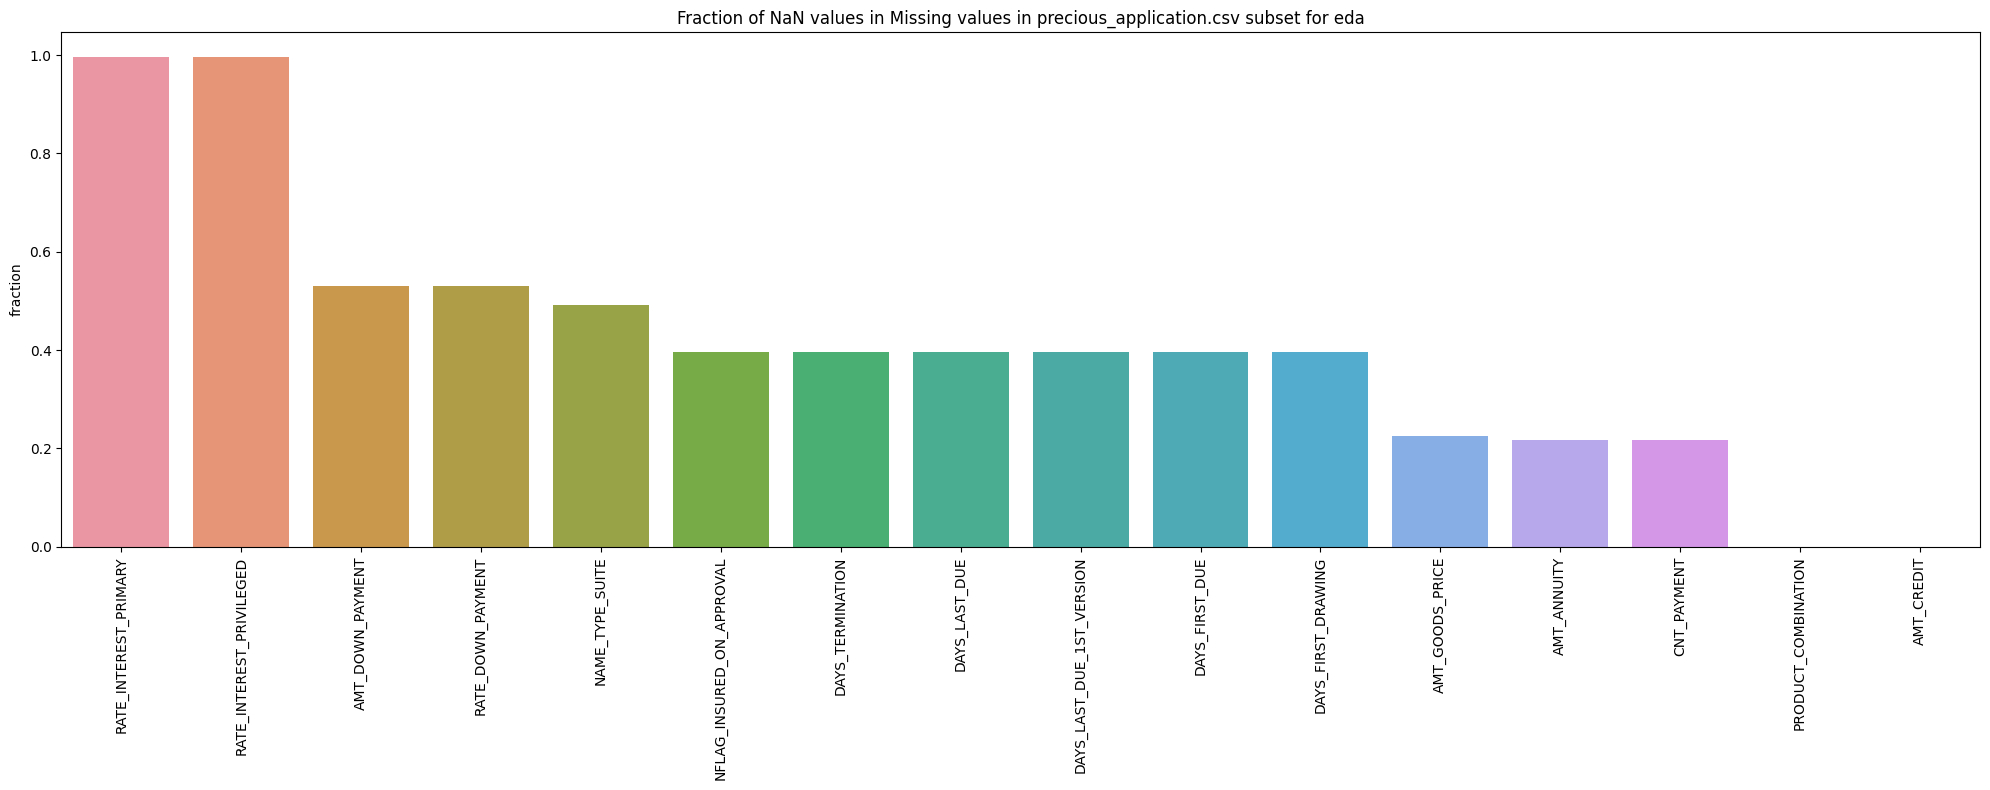

In [40]:
plot_missing(previous_application_eda, 'Missing values in precious_application.csv subset for eda')

### Plotting target variable

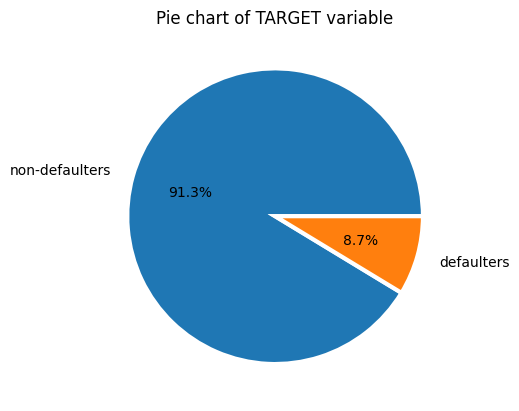

In [26]:
pie_plot(previous_application_eda, 'TARGET', ['non-defaulters', 'defaulters'])

The fraction of defaulters in this dataset is slightly highier which would suggest that defaulters applied more than once previously.

### Categorizing features

In [25]:
# Categorical columns that are of object type
object_col = get_object_columns(previous_application_eda, 'TARGET')

# Categorical features that are encoded
encoded_col = get_cat_encoded_columns(previous_application_eda, 'TARGET')

# Ordinal
ordinal_col = []

# All categorical features
cat_col = object_col + encoded_col

# Numerical continuous variables
num_col = get_num_col(previous_application, encoded_col, 'TARGET', ordinal_col)
num_col.remove('SK_ID_CURR')
num_col.remove('SK_ID_PREV')

### EDA od continuous features

#### Checking significance of correlation with target with anova test

In [27]:
# Getting columns that are correlated with target 
numerical_corr = corr_check_num_cat(previous_application_eda, 'TARGET', num_col)

----------------------------------------------------------------------------------------------------
The columns that are correlated with target column: ['CNT_PAYMENT', 'HOUR_APPR_PROCESS_START', 'DAYS_DECISION', 'SELLERPLACE_AREA', 'DAYS_FIRST_DRAWING', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_FIRST_DUE', 'DAYS_TERMINATION', 'DAYS_LAST_DUE', 'RATE_INTEREST_PRIMARY']
----------------------------------------------------------------------------------------------------


In [28]:
print(f'Number of numerical columns that are not correlated with target: {len(num_col) - len(numerical_corr)}')

Number of numerical columns that are not correlated with target: 7


#### Inspecting and removing multicollinear features

In [29]:
# Displaying Pearson correlations between numerical features correlated to target variable
df_pearson = previous_application_eda[numerical_corr]
pearson_corr_df(df_pearson)

,CNT_PAYMENT,HOUR_APPR_PROCESS_START,DAYS_DECISION,SELLERPLACE_AREA,DAYS_FIRST_DRAWING,DAYS_LAST_DUE_1ST_VERSION,DAYS_FIRST_DUE,DAYS_TERMINATION,DAYS_LAST_DUE,RATE_INTEREST_PRIMARY
CNT_PAYMENT,1.00,-0.06,0.25,-0.01,0.31,-0.38,-0.20,0.06,0.10,-0.01
HOUR_APPR_PROCESS_START,-0.06,1.00,-0.04,0.01,0.01,-0.02,-0.00,-0.02,-0.02,-0.02
DAYS_DECISION,0.25,-0.04,1.00,-0.02,-0.01,0.08,0.18,0.40,0.45,0.01
SELLERPLACE_AREA,-0.01,0.01,-0.02,1.00,0.01,-0.01,-0.00,-0.01,-0.01,0.15
DAYS_FIRST_DRAWING,0.31,0.01,-0.01,0.01,1.00,-0.81,0.00,-0.40,-0.25,nan
DAYS_LAST_DUE_1ST_VERSION,-0.38,-0.02,0.08,-0.01,-0.81,1.00,0.50,0.49,0.42,-0.00
DAYS_FIRST_DUE,-0.20,-0.00,0.18,-0.00,0.00,0.50,1.00,0.32,0.40,-0.01
DAYS_TERMINATION,0.06,-0.02,0.40,-0.01,-0.40,0.49,0.32,1.00,0.93,0.00
DAYS_LAST_DUE,0.10,-0.02,0.45,-0.01,-0.25,0.42,0.40,0.93,1.00,0.00
RATE_INTEREST_PRIMARY,-0.01,-0.02,0.01,0.15,nan,-0.00,-0.01,0.00,0.00,1.00


There are two strong correlations between numerical features:
* DAYS_LAST_DUE_1ST_VERSION - DAYS_FIRST_DRAWING
* DAYS_LAST_DUE - DAYS_TERMINATION

We will remove one of each pair.

In [30]:
# Getting names of multicollinear features
multicollinear_features = ['DAYS_LAST_DUE_1AT_VERSION', 'DAYS_LAST_DUE']

# Getting numerical features that are correlated to the target but not with each other
numerical = [i for i in numerical_corr if i not in multicollinear_features]

#### Checking the strength of correlations with phik, spearman and pearson 

In [32]:
df_corr_num = target_top_corr(previous_application_eda, 'TARGET', numerical)
df_corr_num

,phik_correlation,phik_abs_correlation,spearman_correlation,pearson_correlation
CNT_PAYMENT,0.06,0.06,0.02,0.03
DAYS_DECISION,0.05,0.05,0.04,0.04
DAYS_FIRST_DRAWING,0.05,0.05,-0.03,-0.03
HOUR_APPR_PROCESS_START,0.04,0.04,-0.03,-0.03
DAYS_LAST_DUE_1ST_VERSION,0.03,0.03,0.03,0.02
DAYS_TERMINATION,0.02,0.02,0.02,0.02
RATE_INTEREST_PRIMARY,0.01,0.01,0.02,0.00
DAYS_FIRST_DUE,0.01,0.01,0.02,-0.01
SELLERPLACE_AREA,0.00,0.00,-0.02,-0.00


Only first four features seems to have correlation with the target. We will use them for drawing conclusions from plots. 

In [42]:
num_col_plot = ['CNT_PAYMENT', 'DAYS_DECISION', 'DAYS_FIRST_DRAWING']

#### Displaying meaning of continuous variables that are correlated with the target

In [36]:
names.loc[(names['Table']=='previous_application.csv')&(names['Row'].isin(num_col_plot))][['Row', 'Description', 'Special']]

,Row,Description,Special
185,HOUR_APPR_PROCESS_START,Approximately at what day hour did the client apply for the previous application,rounded
194,DAYS_DECISION,Relative to current application when was the decision about previous application made,time only relative to the application
205,CNT_PAYMENT,Term of previous credit at application of the previous application,NaN
208,DAYS_FIRST_DRAWING,Relative to application date of current application when was the first disbursement of the previous application,time only relative to the application


#### Plotting continuous variables which are correlated with the target

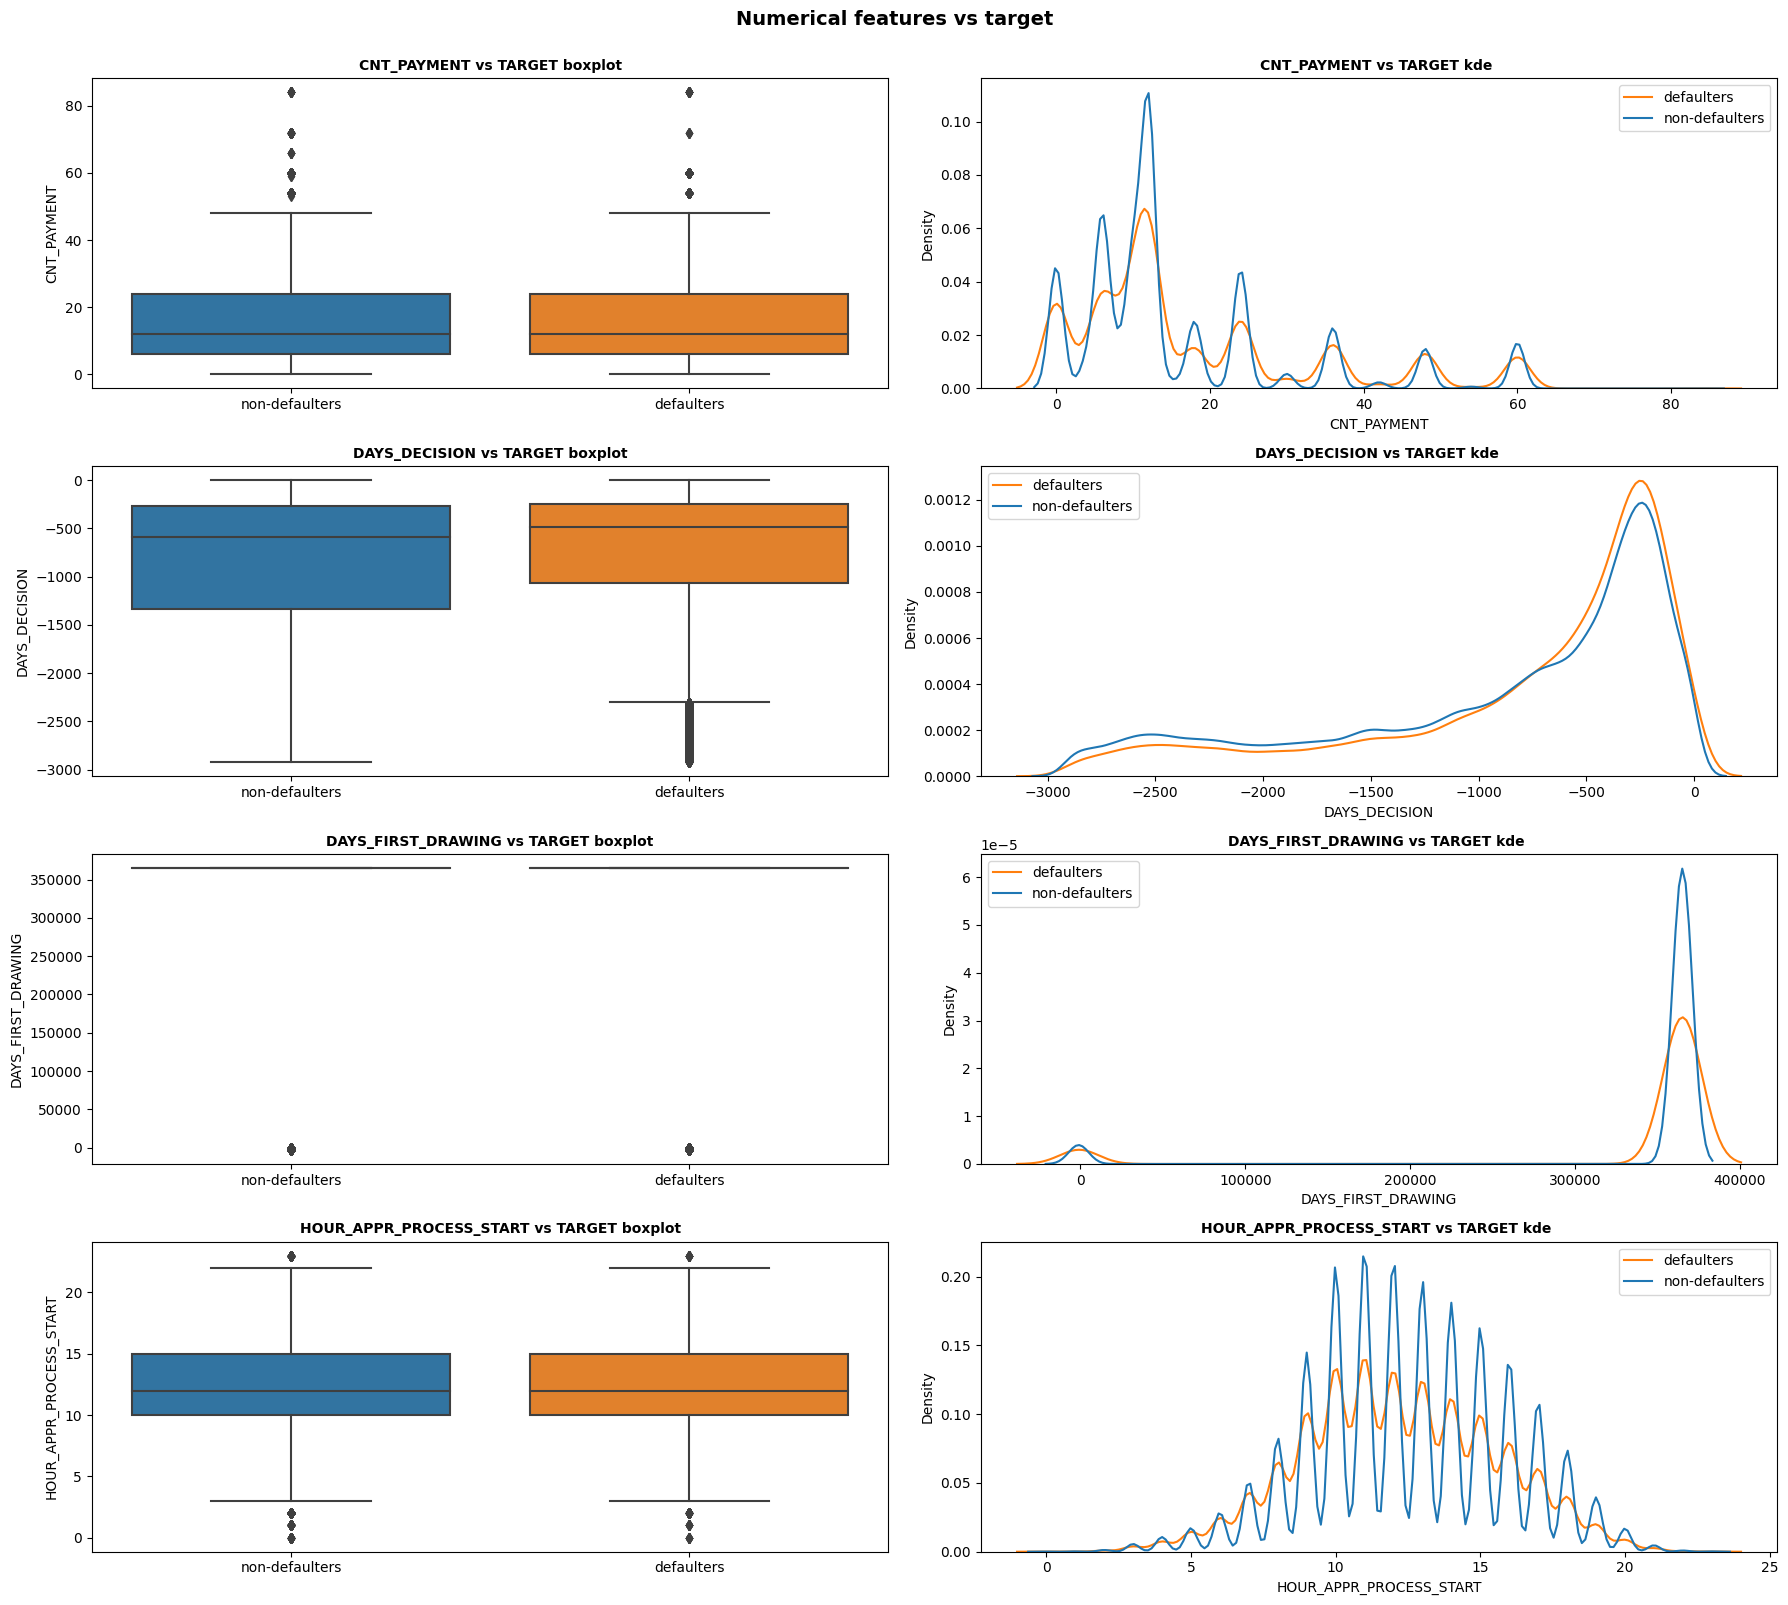

In [38]:
plot_num(previous_application_eda, 'TARGET', num_col_plot, ['non-defaulters', 'defaulters'])

Observations:
* Most clients applied for credits with 10 years term. The variance od application for defaulters were bigger. Credits on apllications were with term up to 50 years with a couple of outliers for longer term credits.
* The decision to either accept or reject the credit was in general made faster for defaulters.
* DAYS_FIRST_DRAWING would need to be clean before further analysis as some values are stated in years, some in days and some are the mixture of both.

### EDA of categorical features

#### Checking significance of correlations with target using chi-square

In [44]:
# Getting categorical features that are correlated to the target
categorical = corr_check_cat_cat(previous_application_eda, 'TARGET', cat_col)

----------------------------------------------------------------------------------------------------
The columns that are correlated with target column: ['PRODUCT_COMBINATION', 'NAME_YIELD_GROUP', 'NAME_CONTRACT_STATUS', 'CODE_REJECT_REASON', 'CHANNEL_TYPE', 'NAME_PRODUCT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_SELLER_INDUSTRY', 'NAME_CASH_LOAN_PURPOSE', 'NAME_PORTFOLIO', 'NAME_CONTRACT_TYPE', 'NAME_PAYMENT_TYPE', 'NAME_CLIENT_TYPE', 'NAME_TYPE_SUITE', 'WEEKDAY_APPR_PROCESS_START', 'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY']
----------------------------------------------------------------------------------------------------


In [45]:
print(f"The number of categorical features that weren't correlated with the target: {len(cat_col) - len(categorical)}")

The number of categorical features that weren't correlated with the target: 1


#### Removing features that are correlated with each other based on spearman correlation.

interval columns not set, guessing: ['NFLAG_LAST_APPL_IN_DAY']


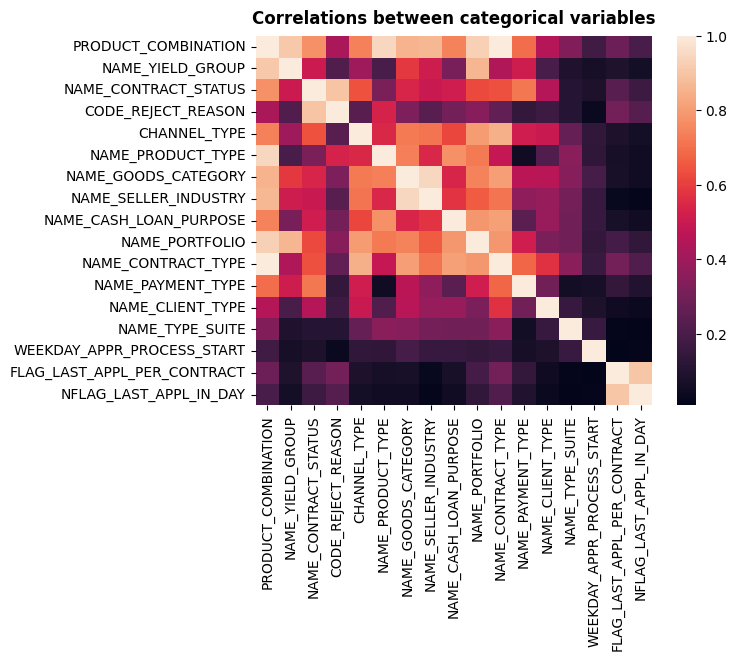

In [49]:
# Checking the correlations between categorical features
from phik import phik_matrix
sns.heatmap(phik_matrix(previous_application_eda[categorical]))
plt.title("Correlations between categorical variables", fontweight='bold', y=1.01);

From the heatmap we see that some of the columns are highly correlated with each other. 

We will remove: 'PRODUCT_COMBINATION', 'NAME_PORTFOLIO', 'CHANNEL_TYPE', 'NAME_CONTRACT_TYPE', 'NAME_PAYMENT_TYPE', 'NFLAG_LAST_APPL_IN_DAY', 'NAME_CONTRACT_STATUS', 'NAME_PRODUCT_TYPE', 'NAME_GOODS_CATEGORY'

In [52]:
to_remove = ['PRODUCT_COMBINATION', 'NAME_PORTFOLIO', 'CHANNEL_TYPE', 'NAME_CONTRACT_TYPE', 
             'NAME_PAYMENT_TYPE', 'NFLAG_LAST_APPL_IN_DAY', 'NAME_CONTRACT_STATUS', 'NAME_PRODUCT_TYPE', 'NAME_GOODS_CATEGORY']
categorical = [x for x in categorical if x not in to_remove]

#### Checking correlations to target with phik test

In [54]:
df_corr_cat = target_top_corr(previous_application_eda, 'TARGET', categorical, numerical=False)
df_corr_cat

,phik_correlation
CODE_REJECT_REASON,0.06
NAME_CASH_LOAN_PURPOSE,0.04
NAME_SELLER_INDUSTRY,0.04
NAME_YIELD_GROUP,0.03
NAME_CLIENT_TYPE,0.02
NAME_TYPE_SUITE,0.02
FLAG_LAST_APPL_PER_CONTRACT,0.01
WEEKDAY_APPR_PROCESS_START,0.01


The correaltions of only first three features seems to be reasonable enough. 

In [55]:
cat_col_plot = ['CODE_REJECT_REASON', 'NAME_CASH_LOAN_PURPOSE', 'NAME_SELLER_INDUSTRY']

#### Displaying meaning of categorical columns with highiest correlations to target

In [56]:
names.loc[(names['Table']=='previous_application.csv')&(names['Row'].isin(cat_col_plot))][['Row', 'Description', 'Special']]

,Row,Description,Special
192,NAME_CASH_LOAN_PURPOSE,Purpose of the cash loan,NaN
196,CODE_REJECT_REASON,Why was the previous application rejected,NaN
204,NAME_SELLER_INDUSTRY,The industry of the seller,NaN


#### Plotting categorical features with highiest correlations to target

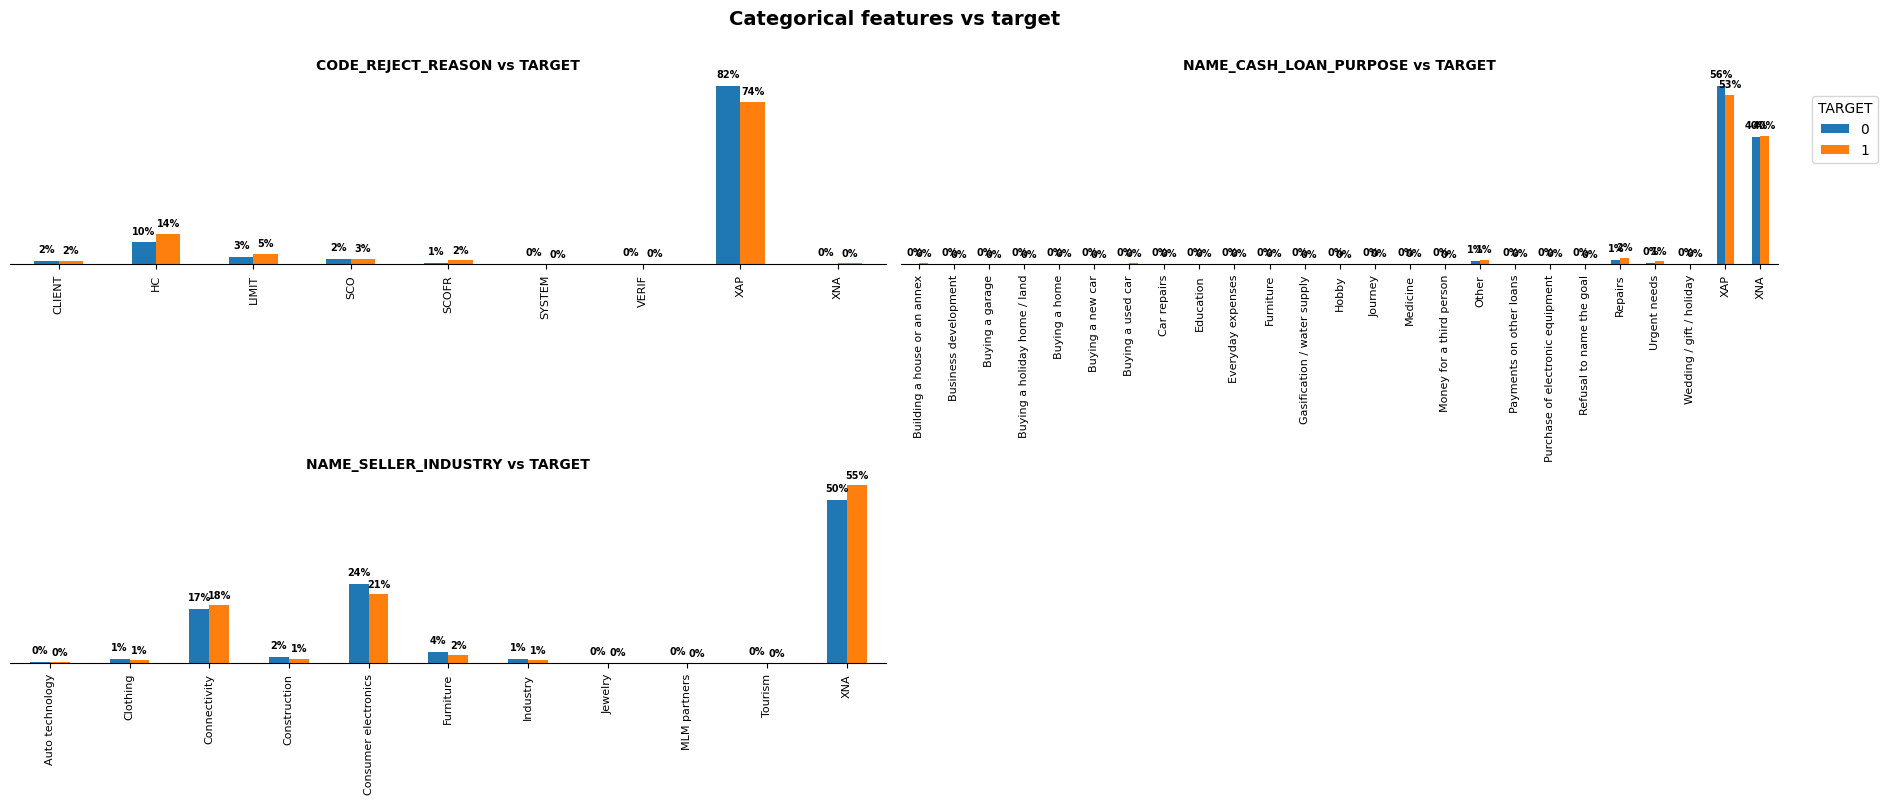

In [57]:
plot_cat_bars(previous_application_eda, 'TARGET', cat_col_plot)

Observations:
* The reason for rejected application was better known for defaulters with previous application with the main one HC (high risk or insufficient credit history)
* Name of cash loan purpose was more oftern unknown for non-defaulters.
* Name of the seller industry was more often unknown for defaulters.

## installments_payments.csv

This table contains repayments of all loans that the applicant had with Home Credit. 

### Loading data

In [13]:
installments_payments = pd.read_csv("installments_payments.csv")
installments_payments.head(2)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.00,6,"-1,180.00","-1,187.00","6,948.36","6,948.36"
1,1330831,151639,0.00,34,"-2,156.00","-2,156.00","1,716.53","1,716.53"


In [14]:
installments_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


### Reducing memory

In [15]:
installments_payments = reduce_memory_usage(installments_payments)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int32  
 1   SK_ID_CURR              int32  
 2   NUM_INSTALMENT_VERSION  float32
 3   NUM_INSTALMENT_NUMBER   int16  
 4   DAYS_INSTALMENT         float32
 5   DAYS_ENTRY_PAYMENT      float32
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float32(3), float64(2), int16(1), int32(2)
memory usage: 493.1 MB
None


### Data for EDA

In [16]:
# Merging previous application with table with target variable and extracting data for analysis
installments_payments_eda = df_eda[['SK_ID_CURR', 'TARGET']].merge(installments_payments, on='SK_ID_CURR', how='inner')
installments_payments_eda.head()

,SK_ID_CURR,TARGET,SK_ID_PREV,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,110584,0,1071225,1.00,10,-221.00,-222.00,"44,435.29","44,435.29"
1,110584,0,1071225,1.00,3,-431.00,-434.00,"44,435.29","44,435.29"
2,110584,0,1071225,1.00,15,-71.00,-72.00,"44,435.29","44,435.29"
3,110584,0,1071225,1.00,12,-161.00,-164.00,"44,435.29","44,435.29"
4,110584,0,1071225,1.00,1,-491.00,-502.00,"44,435.29","44,435.29"


In [17]:
print('-'*100)
print(f'Number of applications without previous installment payment history SK_ID_CURR: {df_eda.shape[0] - len(installments_payments_eda["SK_ID_CURR"].unique())}')
print(f'Number of overlapping SK_ID_CURR: {len(installments_payments_eda["SK_ID_CURR"].unique())}')
print(f'Number of rows: {installments_payments_eda.shape[0]}')
print('-'*100)

----------------------------------------------------------------------------------------------------
Number of applications without previous installment payment history SK_ID_CURR: 12647
Number of overlapping SK_ID_CURR: 233361
Number of rows: 9285531
----------------------------------------------------------------------------------------------------


### Plotting target variable

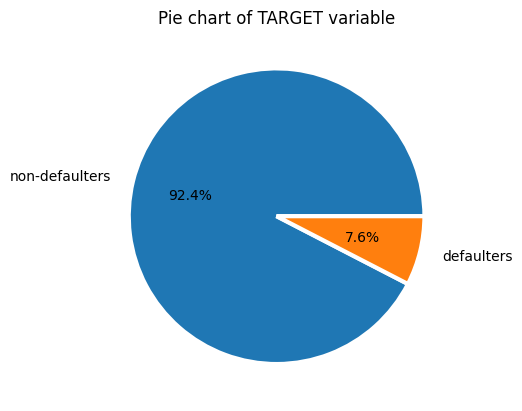

In [18]:
pie_plot(installments_payments_eda, 'TARGET', ['non-defaulters', 'defaulters'])

There percentage of collected installemnts replayments is lower than in application_train data for defaulters. The risk taken with the previous applications could be lower or defaulters are having credits with lower number of repayments. 

### Checking missing values

----------------------------------------------------------------------------------------------------
Number of columns in Missing values in installments_payments.csv subset for eda: 9 columns
Number of columns with missing values in Missing values in installments_payments.csv subset for eda: 2 columns
----------------------------------------------------------------------------------------------------


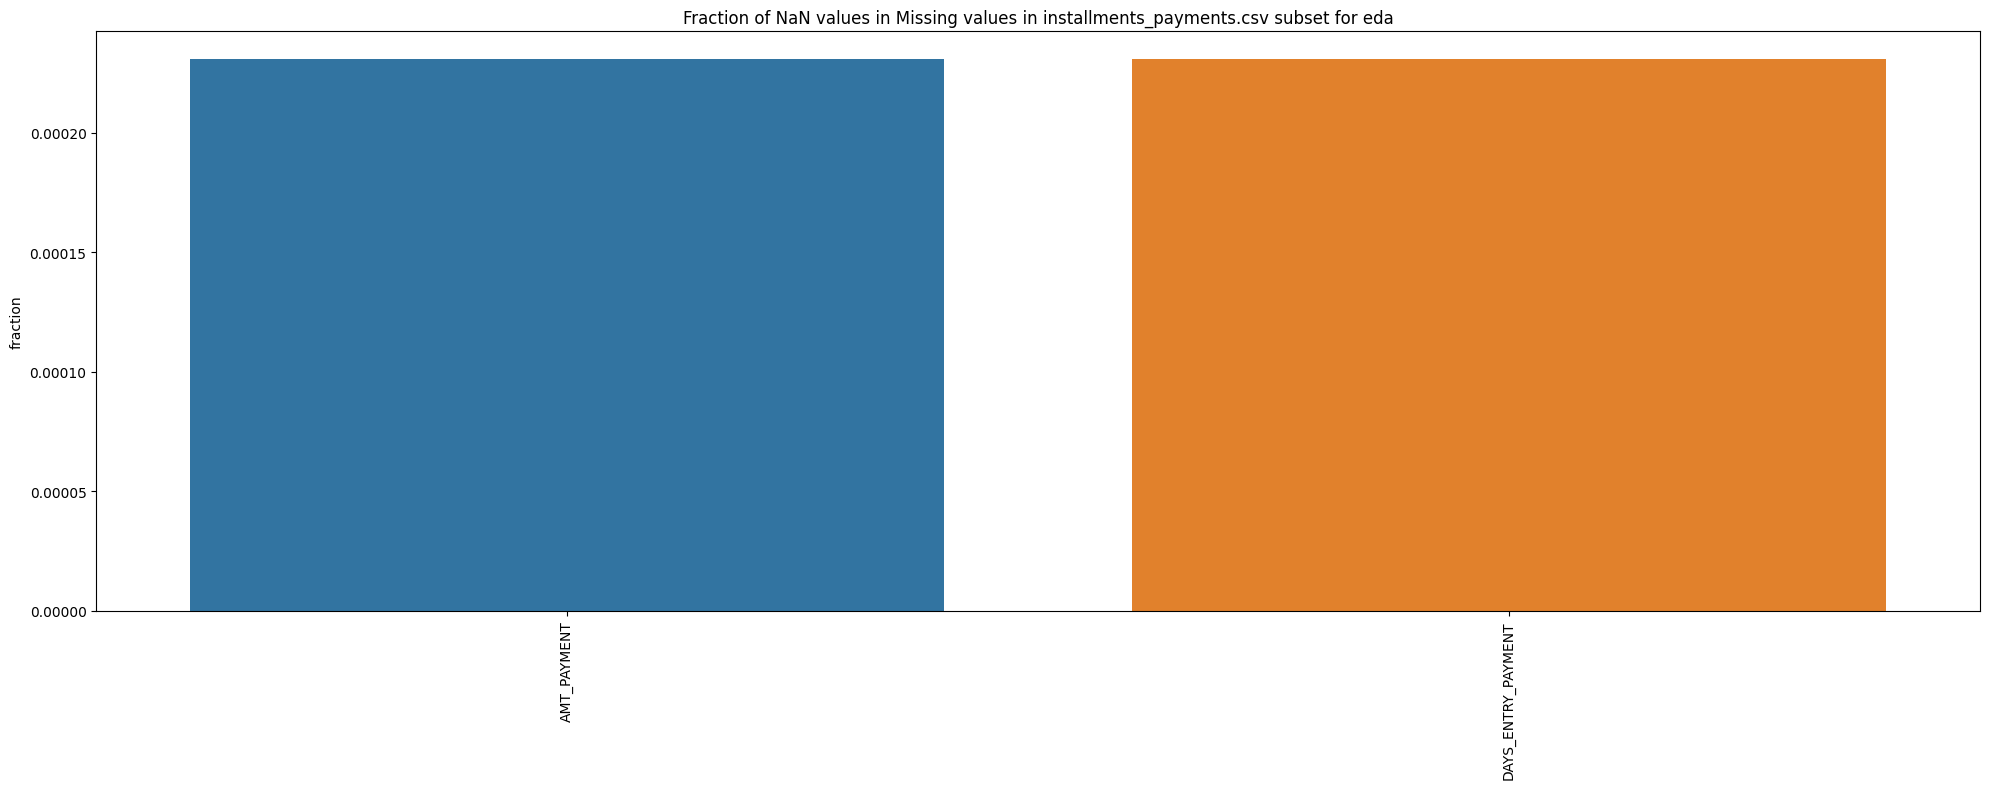

In [19]:
plot_missing(installments_payments_eda, 'Missing values in installments_payments.csv subset for eda')

### Categorizing columns

In [20]:
# Categorical columns that are of object type
object_col = get_object_columns(installments_payments_eda, 'TARGET')

# Categorical features that are encoded
encoded_col = get_cat_encoded_columns(installments_payments_eda, 'TARGET')

# Ordinal
ordinal_col = []

# All categorical features
cat_col = object_col + encoded_col + ordinal_col

# Numerical continuous variables
num_col = get_num_col(installments_payments_eda, encoded_col, 'TARGET', ordinal_col)
num_col.remove('SK_ID_CURR')
num_col.remove('SK_ID_PREV')

### EDA of continuous features

#### Checking columns with significant correlation to target

In [23]:
# Getting columns that are correlated with target 
numerical_corr = corr_check_num_cat(installments_payments_eda, 'TARGET', num_col)

print(f'Number of numerical columns that are not correlated with target: {len(num_col) - len(numerical_corr)}')

----------------------------------------------------------------------------------------------------
The columns that are correlated with target column: ['NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT', 'AMT_INSTALMENT', 'AMT_PAYMENT', 'NUM_INSTALMENT_VERSION']
----------------------------------------------------------------------------------------------------
Number of numerical columns that are not correlated with target: 0


#### Inspecting and removing multicollinear features

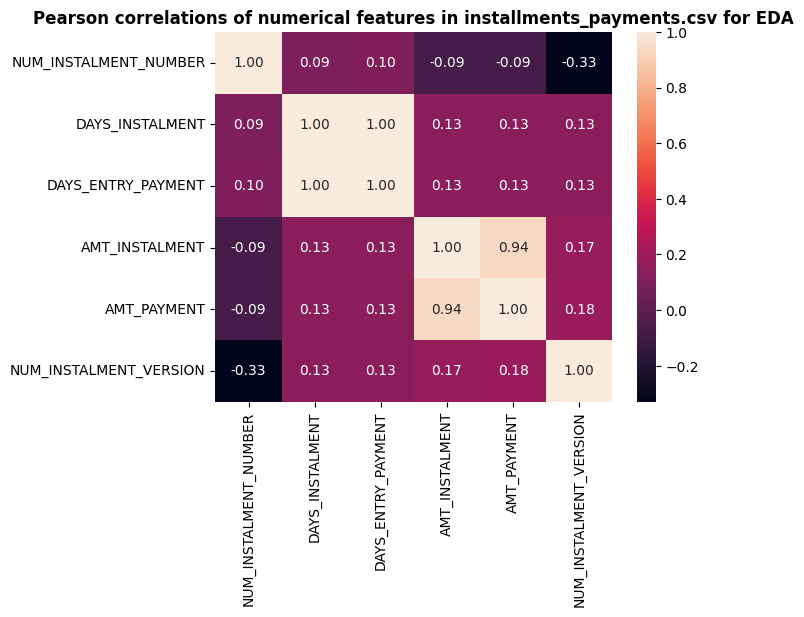

In [24]:
sns.heatmap(installments_payments_eda[numerical_corr].corr(), annot=True, fmt='.2f')
plt.title('Pearson correlations of numerical features in installments_payments.csv for EDA', fontweight='bold');

There are two sets of highly correlated features:
* DAYS_ENTRY_PAYMNET - DAYS_INSTALLMENT
* AMT_PAYMNET - AMT_INSTALMENT

Befor we check the correlations with target we will remove one of each.

In [25]:
# Getting names of multicollinear features
multicollinear_features = ['DAYS_ENTRY_PAYMENT', 'AMT_INSTALMENT']

# Getting numerical features that are correlated to the target but not with each other
numerical = [i for i in numerical_corr if i not in multicollinear_features]

#### Checking correlations of target with not correlated numerical features

In [26]:
df_corr_num = target_top_corr(installments_payments_eda, 'TARGET', numerical)
df_corr_num

,phik_correlation,phik_abs_correlation,spearman_correlation,pearson_correlation
DAYS_INSTALMENT,0.05,0.05,0.04,0.03
NUM_INSTALMENT_NUMBER,0.02,0.02,-0.01,-0.02
AMT_PAYMENT,0.00,0.00,-0.02,-0.00
NUM_INSTALMENT_VERSION,0.00,0.00,-0.01,-0.01


Seems that only DAYS_INSTALMENT has correlation with target that can have a meaningful impact on the predictive model. 

#### Plotting DAYS_INSTALMENT against TARGET variable

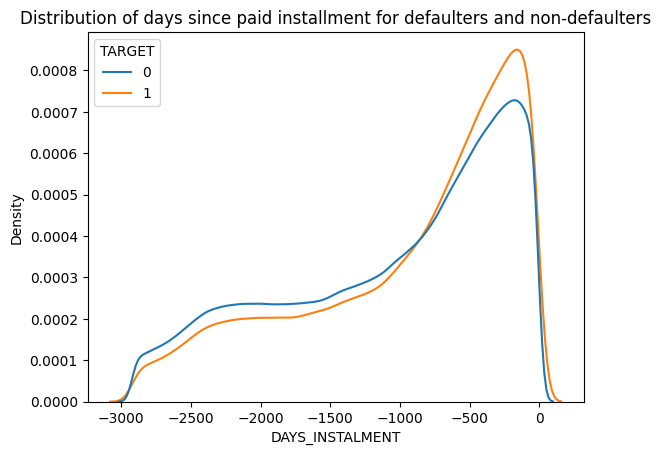

In [29]:
sns.kdeplot(data=installments_payments_eda[['TARGET', 'DAYS_INSTALMENT']].dropna(), x='DAYS_INSTALMENT', hue='TARGET', common_norm=False)
plt.title("Distribution of days since paid installment for defaulters and non-defaulters");

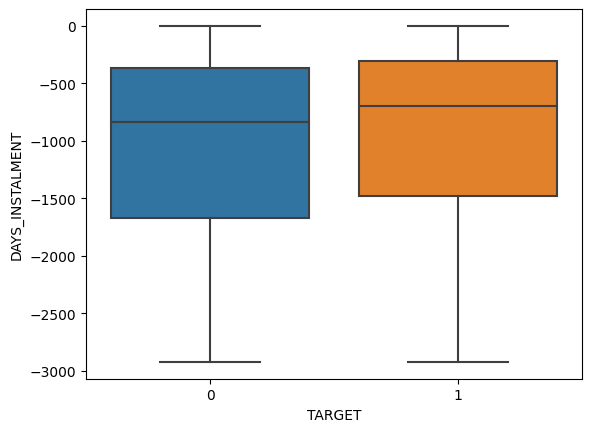

In [34]:
sns.boxplot(data=installments_payments_eda[['TARGET', 'DAYS_INSTALMENT']].dropna(), y='DAYS_INSTALMENT', x='TARGET')
plt.title('Boxplot for days since last paid installment vs. target');

Most of defaulters have fresher history of paying off installments than non-defaulters.

There are no categorical values.

In [38]:
del installments_payments
del installments_payments_eda

## credit_card_balance.csv

The table contains credit cards data from Home Credit.

### Loading data

In [39]:
credit_card = pd.read_csv("credit_card_balance.csv")
credit_card.head(2)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.97,135000,0.00,877.50,0.00,877.50,"1,700.33","1,800.00","1,800.00",0.00,0.00,0.00,0.00,1,0.00,1.00,35.00,Active,0,0
1,2582071,363914,-1,"63,975.56",45000,"2,250.00","2,250.00",0.00,0.00,"2,250.00","2,250.00","2,250.00","60,175.08","64,875.56","64,875.56",1.00,1,0.00,0.00,69.00,Active,0,0


In [40]:
credit_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  CNT_INSTALMENT_MATURE

There are 23 columns in total with one of type object.

### Reduce memory usage

In [41]:
credit_card = reduce_memory_usage(credit_card)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int32  
 1   SK_ID_CURR                  int32  
 2   MONTHS_BALANCE              int8   
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int32  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float32
 16  CNT_DRAWINGS_CURRENT        int16  
 17  CNT_DRAWINGS_OTHER_CURRENT  float32
 18  CNT_DRAWINGS_POS_CURRENT    float32
 19  CNT_INSTALMENT_MATURE

### Data for EDA

In [43]:
# Merging credit cards balance with table with target variable and extracting data for analysis
credit_card_eda = df_eda[['SK_ID_CURR', 'TARGET']].merge(credit_card, on='SK_ID_CURR', how='inner')
credit_card_eda.head(2)

,SK_ID_CURR,TARGET,SK_ID_PREV,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,110584,0,2585761,-4,0.00,0,NaN,0.00,NaN,NaN,0.00,NaN,0.00,0.00,0.00,0.00,NaN,0,NaN,NaN,0.00,Active,0,0
1,110584,0,2585761,-3,0.00,0,NaN,0.00,NaN,NaN,0.00,NaN,0.00,0.00,0.00,0.00,NaN,0,NaN,NaN,0.00,Active,0,0


In [45]:
print('-'*100)
print(f'Number of applications without previous credit cards history SK_ID_CURR: {df_eda.shape[0] - len(credit_card_eda["SK_ID_CURR"].unique())}')
print(f'Number of overlapping SK_ID_CURR: {len(credit_card_eda["SK_ID_CURR"].unique())}')
print(f'Number of rows in data for eda: {credit_card_eda.shape[0]}')
print('-'*100)

----------------------------------------------------------------------------------------------------
Number of applications without previous credit cards history SK_ID_CURR: 176226
Number of overlapping SK_ID_CURR: 69782
Number of rows in data for eda: 2593505
----------------------------------------------------------------------------------------------------


We have more than 2.5 mln entries of months to analyse.

In [46]:
# Freeing memory
del credit_card

### Plotting target variable

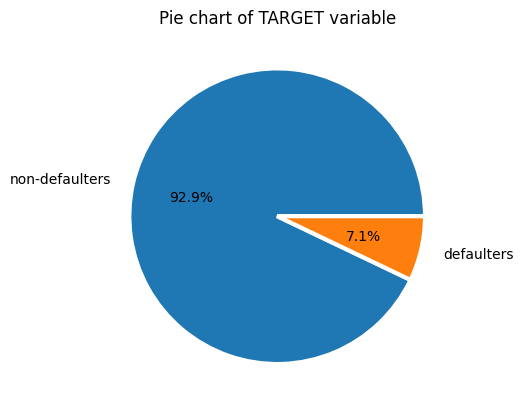

In [47]:
pie_plot(credit_card_eda, 'TARGET', ['non-defaulters', 'defaulters'])

Again we see that there are less defaulters than in application_train.csv which agrees with the intuition that it's easier to pay of smaller amounts on credit cards.

### Inspecting missing values

----------------------------------------------------------------------------------------------------
Number of columns in Missing values in installments_payments.csv subset for eda: 24 columns
Number of columns with missing values in Missing values in installments_payments.csv subset for eda: 9 columns
----------------------------------------------------------------------------------------------------


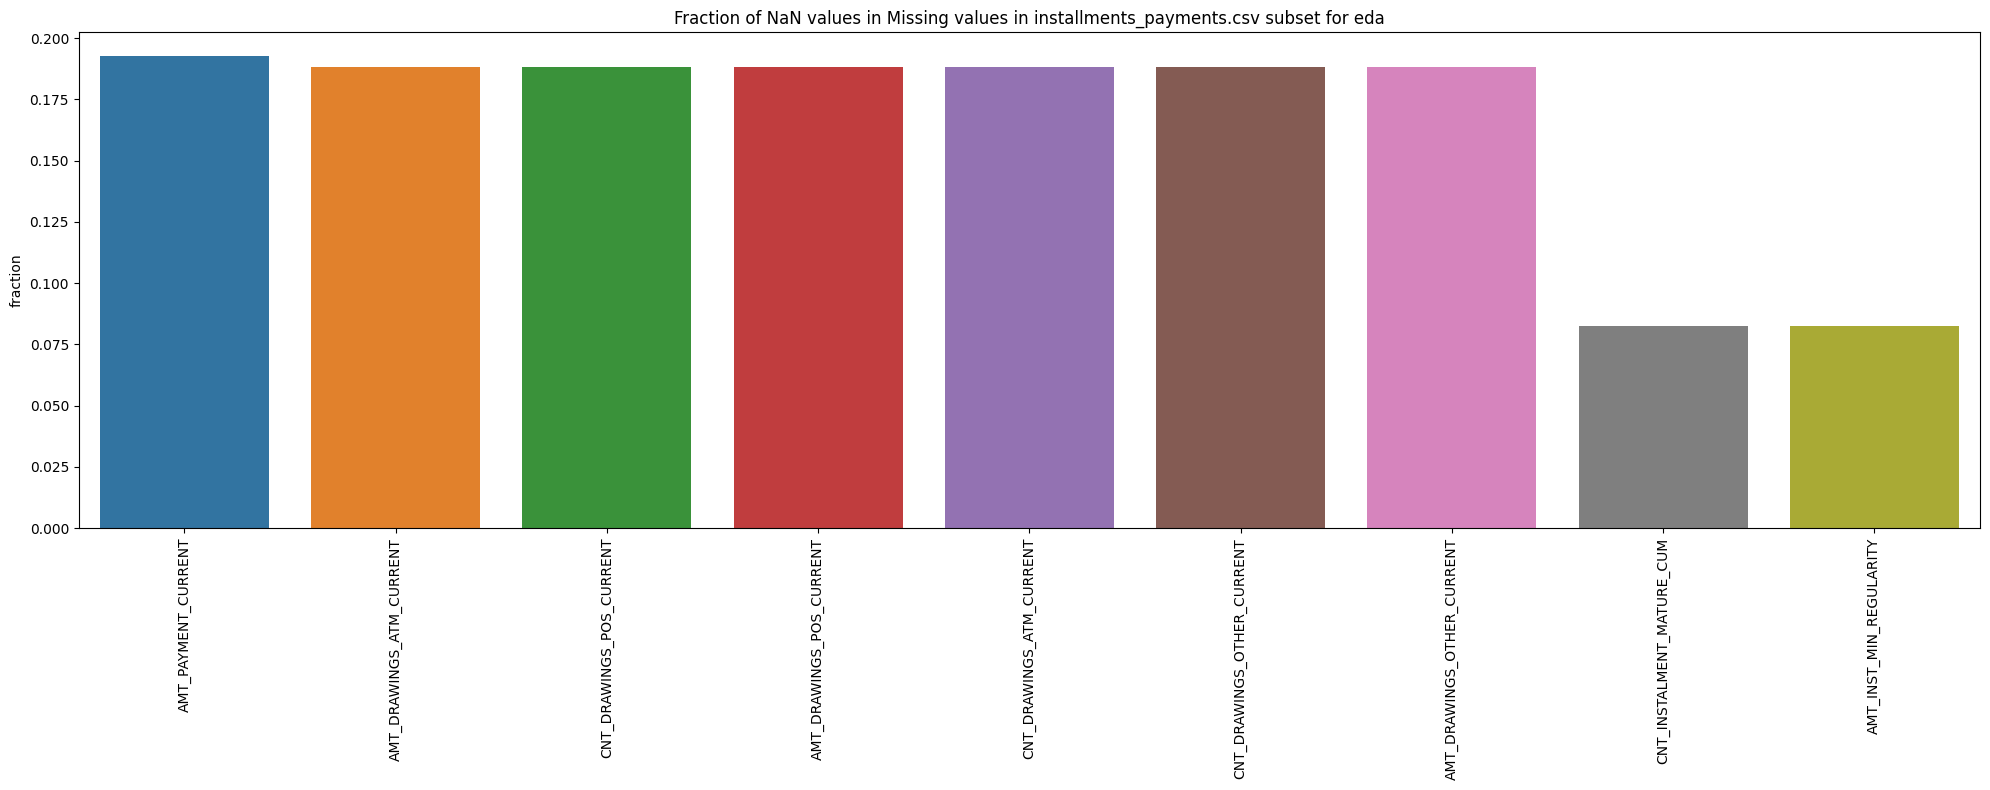

In [48]:
plot_missing(credit_card_eda, 'Missing values in installments_payments.csv subset for eda')

7 columns have around 20% of missing values.

### Categorizing columns

In [50]:
# Categorical columns that are of object type
object_col = get_object_columns(credit_card_eda, 'TARGET')

# Categorical features that are encoded
encoded_col = get_cat_encoded_columns(credit_card_eda, 'TARGET')

# Ordinal
ordinal_col = []

# All categorical features
cat_col = object_col + encoded_col + ordinal_col

# Numerical continuous variables
num_col = get_num_col(credit_card_eda, encoded_col, 'TARGET', ordinal_col)
num_col.remove('SK_ID_CURR')
num_col.remove('SK_ID_PREV')

### EDA of continuous features

#### Checking columns which are correlated with confidence level 0.95

In [52]:
# Getting columns that are correlated with target 
numerical_corr = corr_check_num_cat(credit_card_eda, 'TARGET', num_col)

print(f'Number of numerical columns that are not correlated with target: {len(num_col) - len(numerical_corr)}')

----------------------------------------------------------------------------------------------------
The columns that are correlated with target column: ['MONTHS_BALANCE', 'AMT_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT', 'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY', 'AMT_PAYMENT_CURRENT', 'AMT_TOTAL_RECEIVABLE', 'AMT_PAYMENT_TOTAL_CURRENT', 'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'CNT_DRAWINGS_CURRENT', 'CNT_DRAWINGS_ATM_CURRENT', 'CNT_INSTALMENT_MATURE_CUM', 'CNT_DRAWINGS_POS_CURRENT', 'SK_DPD_DEF', 'SK_DPD', 'AMT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_OTHER_CURRENT']
----------------------------------------------------------------------------------------------------
Number of numerical columns that are not correlated with target: 0


#### Inspecting and removing multicollinear features

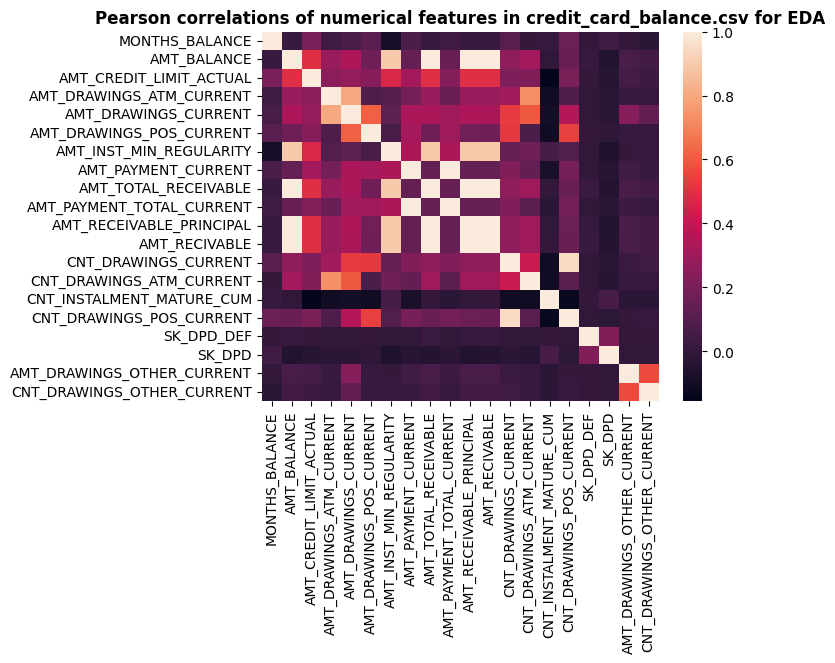

In [55]:
sns.heatmap(credit_card_eda[numerical_corr].corr())
plt.title('Pearson correlations of numerical features in credit_card_balance.csv for EDA', fontweight='bold');